In [266]:
# %pip install pm4py==2.7.4
# !brew install graphviz
# !pip install pygraphviz

In [267]:
import pandas as pd
import os
import pm4py
import re
import json

from functools import reduce
from itertools import groupby
from itertools import chain
from more_itertools import pairwise
from collections import Counter
import pygraphviz as pgv
from IPython.display import Image, display
from datetime import datetime
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
import xml.etree.ElementTree as ET
import pygraphviz as pgv
from itertools import pairwise
import itertools
from collections import Counter, ChainMap

In [268]:
log_small_data = pm4py.format_dataframe(pd.read_csv("flight_event_log.csv", sep=','), case_id='Flight', activity_key='Activity', timestamp_key='Timestamp')

log_medium_data = pm4py.format_dataframe(pd.read_csv("p2p_event_log.csv", sep=','), case_id='Case ID', activity_key='ACTIVITY', timestamp_key='EVENTTIME')

log_big_data = pm4py.format_dataframe(pd.read_csv("teleclaims.csv", sep=','), case_id='Case ID', activity_key='Activity', timestamp_key='Complete Timestamp')

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/opt/anaconda3/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/opt/anaconda3/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/opt/anaconda3/lib/python3.11/site-pa

parsing log, completed traces ::   0%|          | 0/10 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/opt/anaconda3/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/opt/anaconda3/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/opt/anaconda3/lib/python3.11/site-pa

Grouping

In [275]:
log_small_data['Timestamp'] = pd.to_datetime(log_small_data['Timestamp'])

log_small_data_routes = (log_small_data
                         .sort_values(by=['Flight', 'Timestamp'])
                         .groupby(['Flight'])
                         .agg({'Activity': ';'.join})
                         )

log_small_data_routes['count'] = 0
log_small_data_routes = (log_small_data_routes.groupby('Activity', as_index=False)
                         .count()
                         .sort_values(['count'], ascending=False)
                         .reset_index(drop=True)
                         )

In [276]:
log_medium_data['EVENTTIME'] = pd.to_datetime(log_medium_data['EVENTTIME'])

log_medium_data_routes = (log_medium_data
                          .sort_values(by=['Case ID', 'EVENTTIME'])
                          .groupby('Case ID', as_index=False)
                          .agg({'ACTIVITY': ';'.join}))

log_medium_data_routes['count'] = 1
log_medium_data_routes = (log_medium_data_routes.groupby('ACTIVITY', as_index=False)
                          .agg({'count': 'sum'})
                          .sort_values(by='count', ascending=False)
                          .reset_index(drop=True))

In [277]:
log_big_data['Complete Timestamp'] = pd.to_datetime(log_big_data['Complete Timestamp'])

log_sorted = log_big_data.sort_values(by=['Case ID', 'Complete Timestamp'])

log_big_data_routes = (log_sorted
                       .groupby('Case ID', as_index=False)
                       .agg({'Activity': ';'.join}))

log_big_data_routes['count'] = 1
log_big_data_routes = (log_big_data_routes.groupby('Activity', as_index=False)
                       .agg({'count': 'sum'})
                       .sort_values(by='count', ascending=False)
                       .reset_index(drop=True))

Direct follow graph

In [283]:
def draw_graph_small(log):
    log['trace'] = [trace.split(';') for trace in log['Activity']]

    w_net = dict()
    for index, row in log[['trace', 'count']].iterrows():
        for ev_i, ev_j in pairwise(row['trace']):
            if ev_i not in w_net.keys():
                w_net[ev_i] = Counter()
            w_net[ev_i][ev_j] += row['count']

    G = pgv.AGraph(strict=False, directed=True)
    G.graph_attr['rankdir'] = 'LR'
    G.node_attr['shape'] = 'Mrecord'
    for event, successors in w_net.items():
        G.add_node(event, style="rounded,filled", fillcolor="#ffffcc")
        for succ, weight in successors.items():
            G.add_edge(event, succ, label=str(weight))
    G.draw('solution.png', prog='dot')
    display(Image('solution.png'))

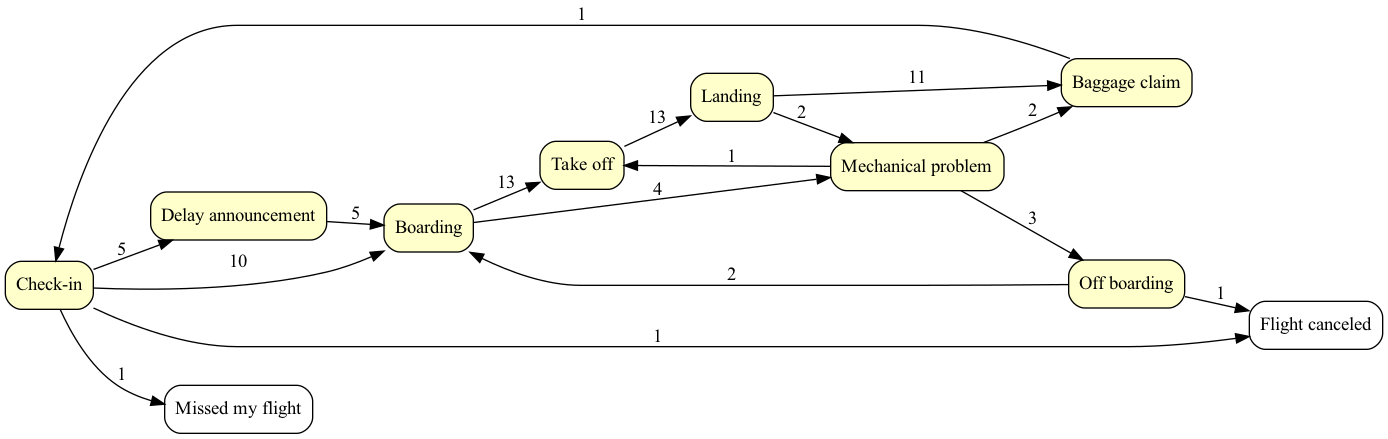

In [284]:
draw_graph_small(log_small_data_routes)

In [285]:
def draw_graph_medium(log):
    log['trace'] = [trace.split(';') for trace in log['ACTIVITY']]

    w_net = dict()
    for index, row in log[['trace', 'count']].iterrows():
        for ev_i, ev_j in pairwise(row['trace']):
            if ev_i not in w_net.keys():
                w_net[ev_i] = Counter()
            w_net[ev_i][ev_j] += row['count']

    G = pgv.AGraph(strict=False, directed=True)
    G.graph_attr['rankdir'] = 'LR'
    G.node_attr['shape'] = 'Mrecord'
    for event, successors in w_net.items():
        G.add_node(event, style="rounded,filled", fillcolor="#ffffcc")
        for sc, weight in successors.items():
            G.add_edge(event, sc, label=str(weight))
    G.draw('solution.png', prog='dot')
    display(Image('solution.png'))

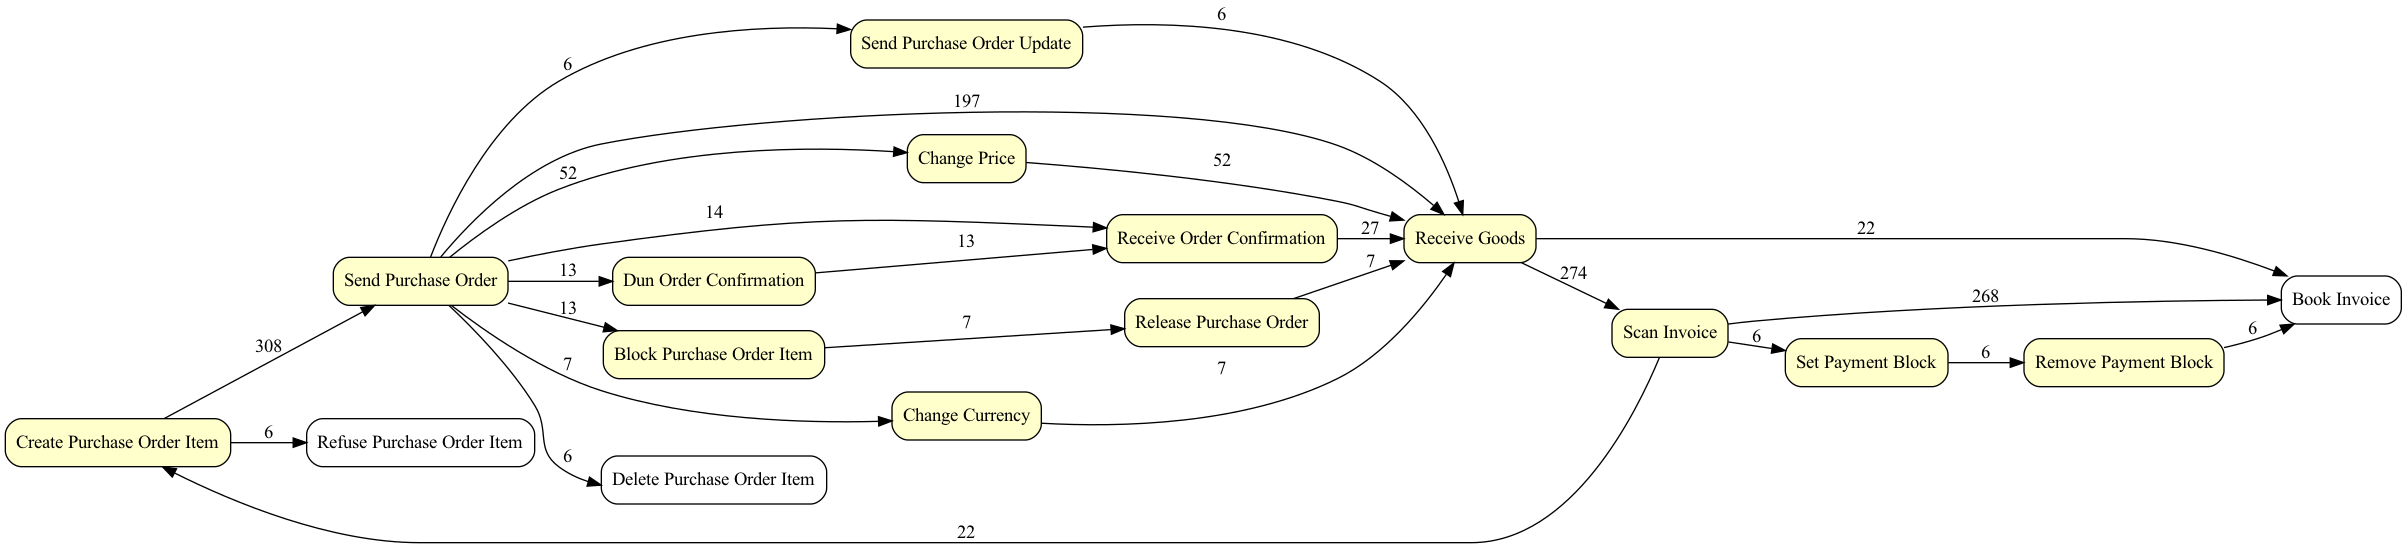

In [286]:
draw_graph_medium(log_medium_data_routes)

In [287]:
def draw_graph_big(log):
    if not isinstance(log, pd.DataFrame):
        raise ValueError("Input log must be a pandas DataFrame")
    
    log['trace'] = log['Activity'].apply(lambda x: x.split(';'))

    w_net = {}
    ev_start_set, ev_end_set = set(), set()

    for trace, count in zip(log['trace'], log['count']):
        ev_start_set.add(trace[0])
        ev_end_set.add(trace[-1])
        for ev_i, ev_j in itertools.pairwise(trace):
            if ev_i not in w_net:
                w_net[ev_i] = Counter()
            w_net[ev_i][ev_j] += count

    G = pgv.AGraph(strict=False, directed=True)
    G.graph_attr['rankdir'] = 'LR'
    G.node_attr['shape'] = 'Mrecord'

    for event, successors in w_net.items():
        G.add_node(event, style="rounded,filled", fillcolor="#ffffcc")
        for successor, weight in successors.items():
            G.add_edge(event, successor, label=str(weight))

    image_path = 'solution.png'
    G.draw(image_path, prog='dot')
    display(Image(image_path))

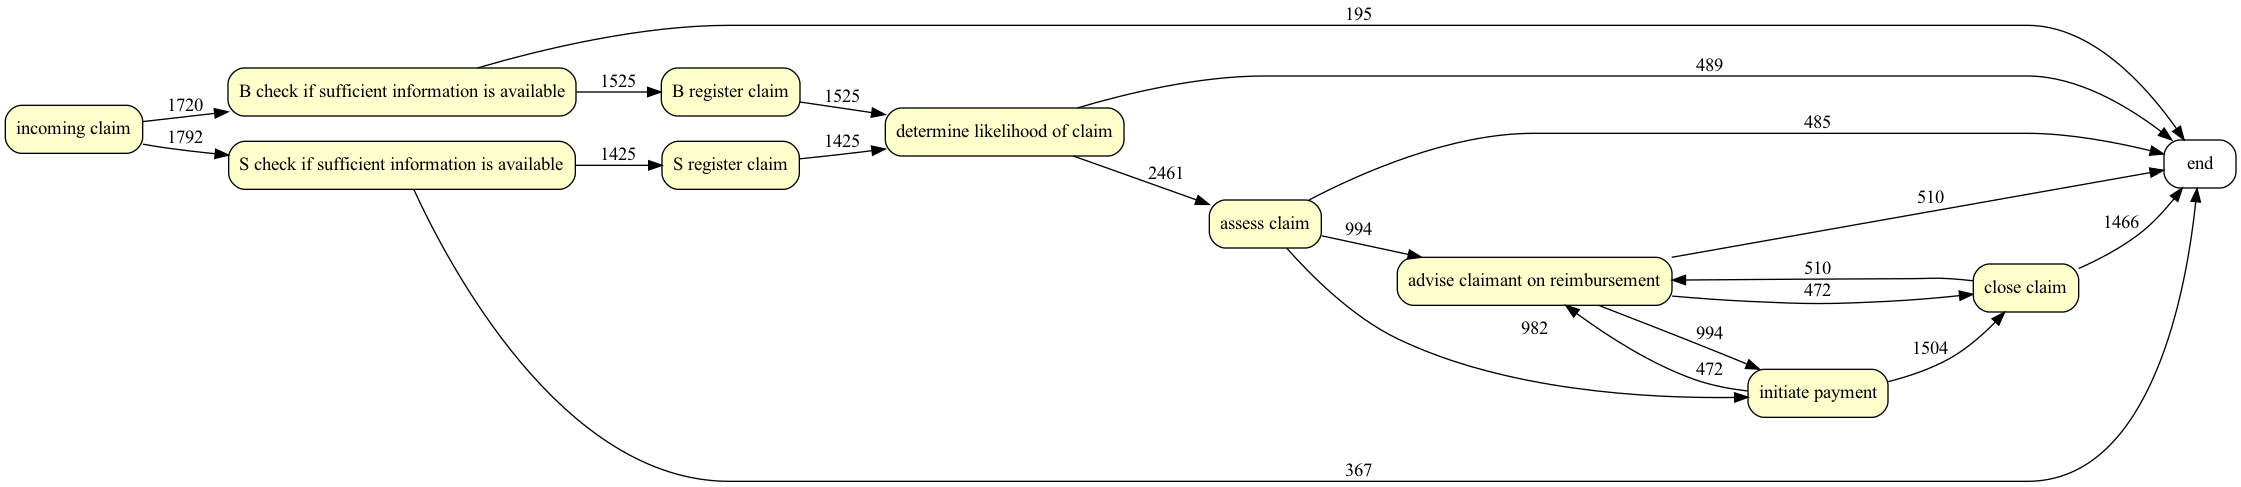

In [288]:
draw_graph_big(log_big_data_routes)

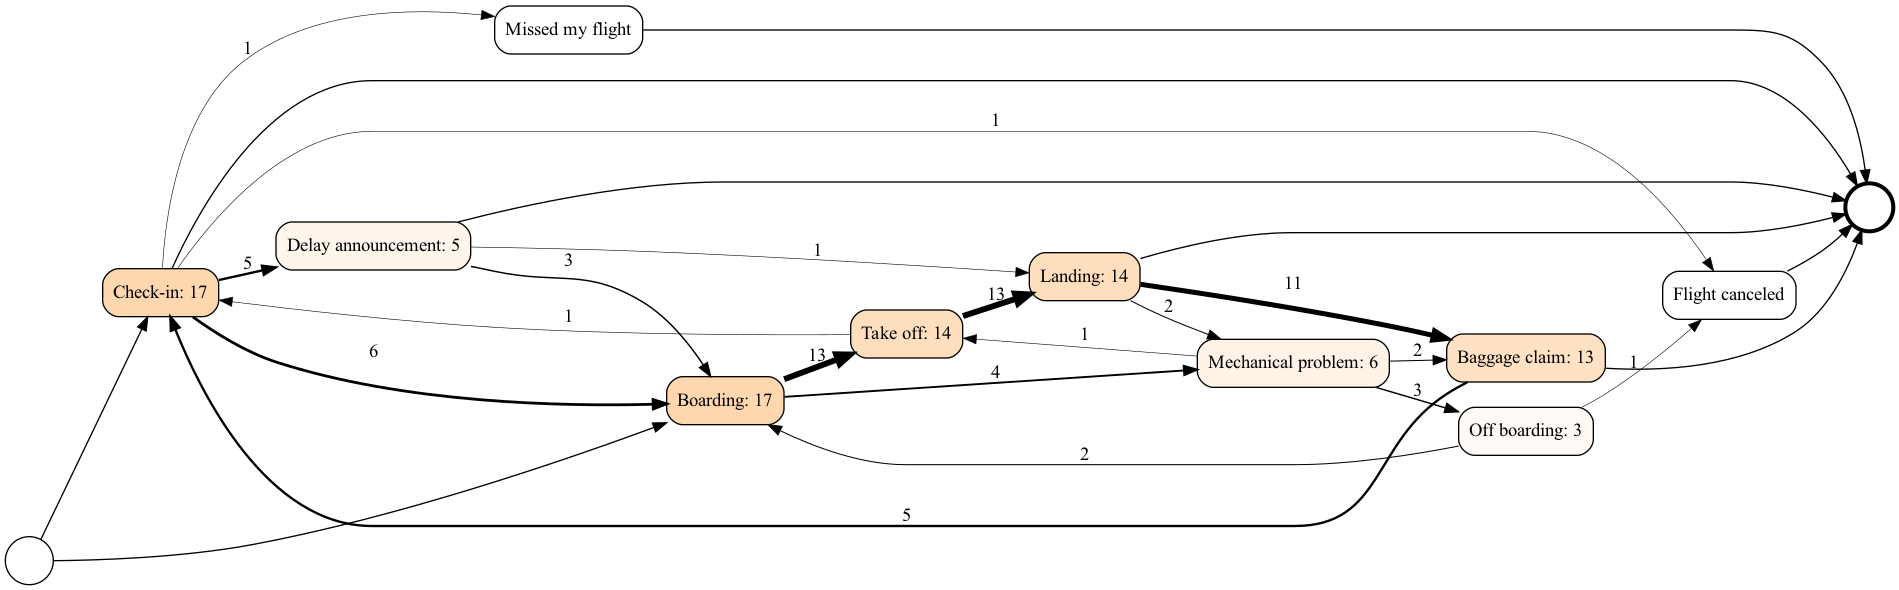

In [294]:
def draw_graph_small(dfs, flight='Flight', timestamp='Timestamp', activity='Activity'):
    ev_counter = dfs[activity].value_counts()

    dfs = (dfs
           .sort_values(by=[flight, timestamp])
           .groupby([flight])
           .agg({activity: ';'.join})
           )
    dfs['count'] = 0
    dfs = (dfs.groupby(activity, as_index=False).count()
           .sort_values(['count'], ascending=False)
           .reset_index(drop=True))

    dfs['trace'] = [trace.split(';') for trace in dfs[activity]]

    w_net = dict()
    ev_start_set = set()
    ev_end_set = set()
    for index, row in dfs[['trace', 'count']].iterrows():
        if row['trace'][0] not in ev_start_set:
            ev_start_set.add(row['trace'][0])
        if row['trace'][-1] not in ev_end_set:
            ev_end_set.add(row['trace'][-1])
        for ev_i, ev_j in pairwise(row['trace']):
            if ev_i not in w_net:
                w_net[ev_i] = Counter()
            w_net[ev_i][ev_j] += row['count']

    trace_counts = sorted(chain(*[c.values() for c in w_net.values()]))
    trace_min, trace_max = trace_counts[0], trace_counts[-1]
    color_min, color_max = ev_counter.min(), ev_counter.max()

    G = pgv.AGraph(strict=False, directed=True)
    G.graph_attr['rankdir'] = 'LR'
    G.node_attr['shape'] = 'Mrecord'

    G.add_node("start", shape="circle", label="")
    for ev_start in ev_start_set:
        G.add_edge("start", ev_start)
    G.add_node("end", shape="circle", label="", penwidth='3')
    for ev_end in ev_end_set:
        G.add_edge(ev_end, "end")

    for event, successors in w_net.items():
        value = ev_counter[event]
        color = int(float(color_min - value) / float(color_min - color_max) * 100.00)
        label = f"{event}: {ev_counter[event]}"
        my_color = "#ff9933" + str(hex(color))[2:]
        G.add_node(event, style="rounded,filled", fillcolor=my_color, label=label)
        for successor, cnt in successors.items():
            G.add_edge(event, successor, penwidth=4 * cnt / (trace_max - trace_min) + 0.1, label=cnt)

    output_file = 'solution.png'
    G.draw(output_file, prog='dot')
    display(Image(output_file))

df = pd.read_csv('flight_event_log.csv')

draw_graph_small(df)

In [295]:
def draw_graph_medium(dfs, case_id, timestamp, activity):
    ev_counter = dfs[activity].value_counts()

    dfs = (dfs.sort_values(by=[case_id, timestamp])
           .groupby([case_id])
           .agg({activity: ';'.join}))
    dfs['count'] = 0
    dfs = (dfs.groupby(activity, as_index=False)
           .count()
           .sort_values(['count'], ascending=False)
           .reset_index(drop=True))
    dfs['trace'] = [trace.split(';') for trace in dfs[activity]]

    w_net = dict()
    ev_start_set = set()
    ev_end_set = set()
    for index, row in dfs[['trace', 'count']].iterrows():
        if row['trace'][0] not in ev_start_set:
            ev_start_set.add(row['trace'][0])
        if row['trace'][-1] not in ev_end_set:
            ev_end_set.add(row['trace'][-1])
        for ev_i, ev_j in pairwise(row['trace']):
            if ev_i not in w_net.keys():
                w_net[ev_i] = Counter()
            w_net[ev_i][ev_j] += row['count']

    trace_counts = sorted(chain(*[c.values() for c in w_net.values()]))
    trace_min = trace_counts[0]
    trace_max = trace_counts[-1]
    color_min = ev_counter.min()
    color_max = ev_counter.max()

    G = pgv.AGraph(strict=False, directed=True)
    G.graph_attr['rankdir'] = 'LR'
    G.node_attr['shape'] = 'Mrecord'

    G.add_node("start", shape="circle", label="")
    for ev_start in ev_start_set:
        G.add_edge("start", ev_start)

    for event, successors in w_net.items():
        value = ev_counter[event]
        color = int(float(color_min - value) / float(color_min - color_max) * 100.00)
        label = f"{event}: {ev_counter[event]}"
        my_color = f"#ff9933{hex(color)[2:]}"
        G.add_node(event, style="rounded,filled", fillcolor=my_color, label=label)
        for successor, cnt in successors.items():
            G.add_edge(event, successor, penwidth=4 * cnt / (trace_max - trace_min) + 0.1, label=cnt)

    G.add_node("end", shape="circle", label="", penwidth='3')
    for ev_end in ev_end_set:
        G.add_edge(ev_end, "end")

    G.draw('solution.png', prog='dot')
    display(Image('solution.png'))

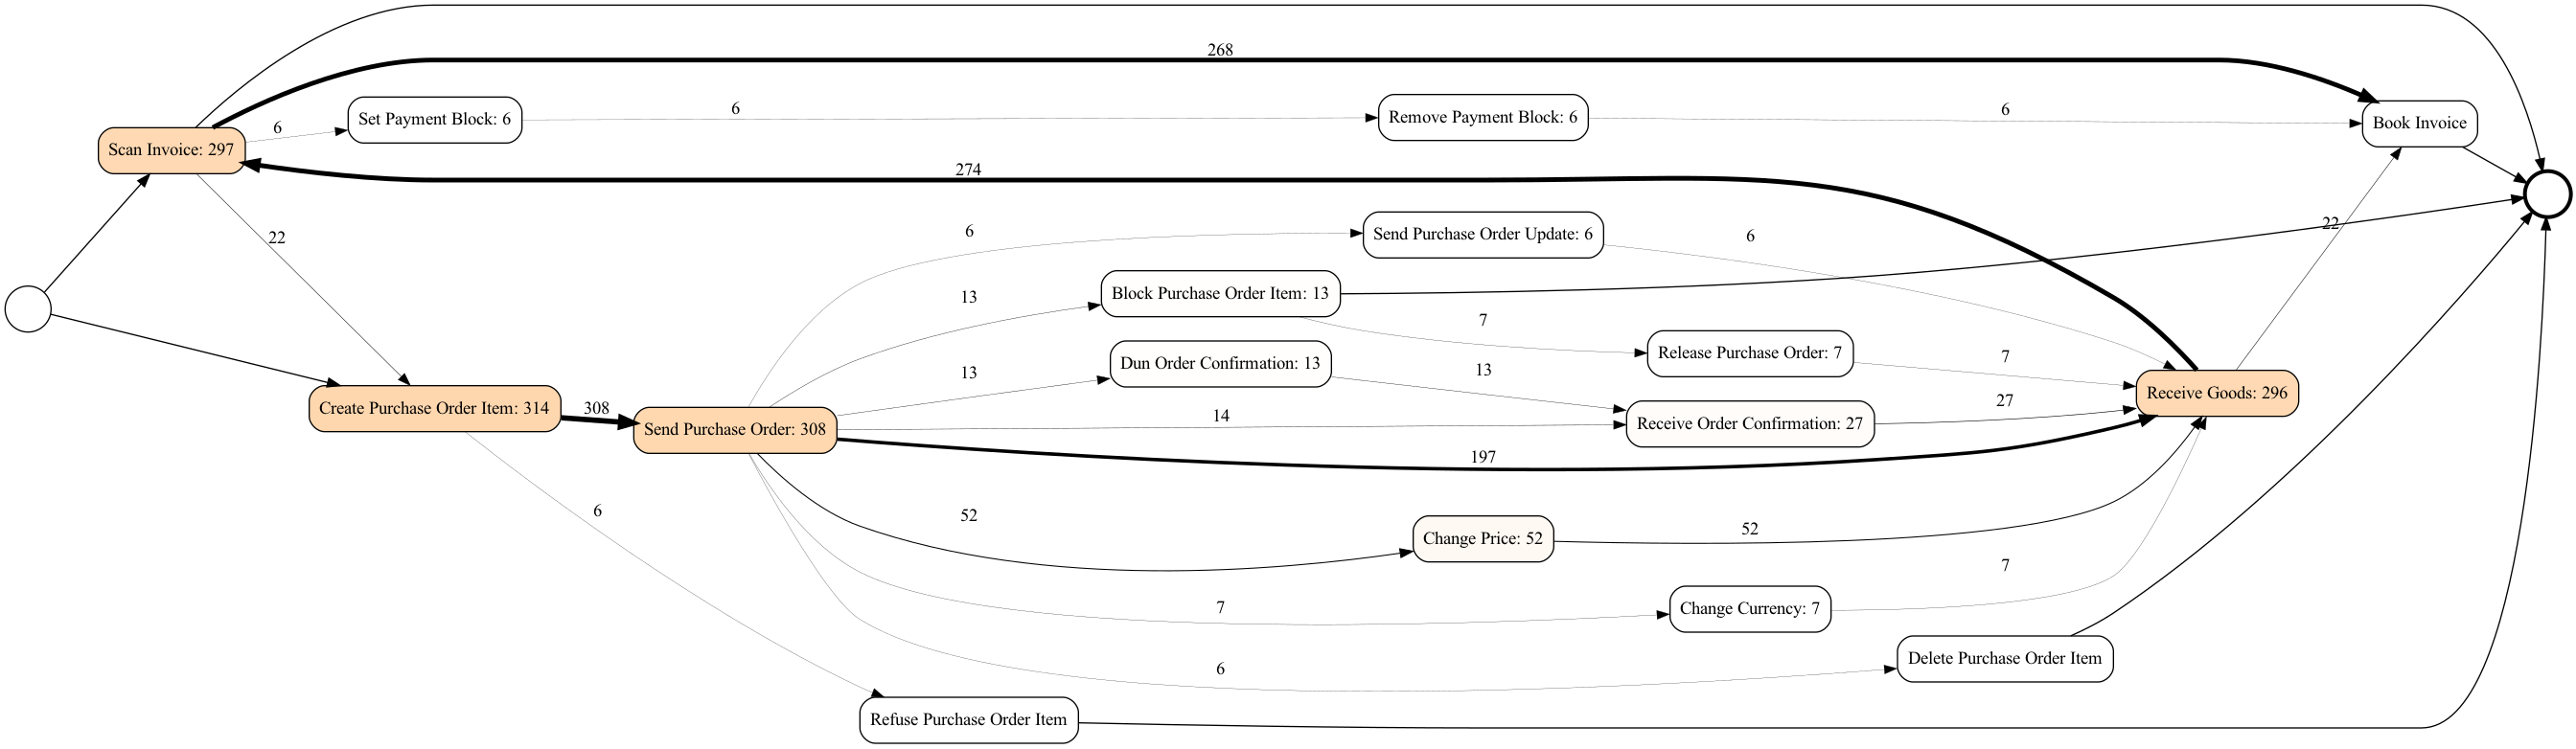

In [296]:
draw_graph_medium(log_medium_data, 'Case ID', 'EVENTTIME', 'ACTIVITY')

In [297]:
def draw_graph_big(dfs, case_id='Case ID', timestamp='Complete Timestamp', activity='Activity'):
    if not isinstance(dfs, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")

    ev_counter = dfs[activity].value_counts()

    dfs = (dfs.sort_values(by=[case_id, timestamp])
           .groupby(case_id)
           .agg({activity: ';'.join}))
    dfs['count'] = 0
    dfs = (dfs.groupby(activity, as_index=False)
           .count()
           .sort_values('count', ascending=False)
           .reset_index(drop=True))
    dfs['trace'] = dfs[activity].apply(lambda x: x.split(';'))

    w_net = {}
    ev_start_set, ev_end_set = set(), set()
    for trace, count in zip(dfs['trace'], dfs['count']):
        ev_start_set.add(trace[0])
        ev_end_set.add(trace[-1])
        for ev_i, ev_j in itertools.pairwise(trace):
            w_net.setdefault(ev_i, Counter())[ev_j] += count

    trace_counts = sorted(ChainMap(*w_net.values()).values())
    trace_min, trace_max = trace_counts[0], trace_counts[-1]
    color_min, color_max = ev_counter.min(), ev_counter.max()

    # Creating the graph
    G = pgv.AGraph(strict=False, directed=True)
    G.graph_attr['rankdir'] = 'LR'
    G.node_attr['shape'] = 'Mrecord'

    G.add_node("start", shape="circle", label="")
    G.add_node("end", shape="circle", label="", penwidth='3')

    for event, successors in w_net.items():
        value = ev_counter[event]
        color = int((color_min - value) / (color_min - color_max) * 100.00)
        label = f"{event}: {value}"
        node_color = f"#ff9933{hex(color)[2:]}"
        G.add_node(event, style="rounded,filled", fillcolor=node_color, label=label)
        for successor, count in successors.items():
            edge_width = 4 * count / (trace_max - trace_min) + 0.1
            G.add_edge(event, successor, penwidth=edge_width, label=count)

    for ev_start in ev_start_set:
        G.add_edge("start", ev_start)
    for ev_end in ev_end_set:
        G.add_edge(ev_end, "end")

    filename = 'solution.png'
    G.draw(filename, prog='dot')
    display(Image(filename))

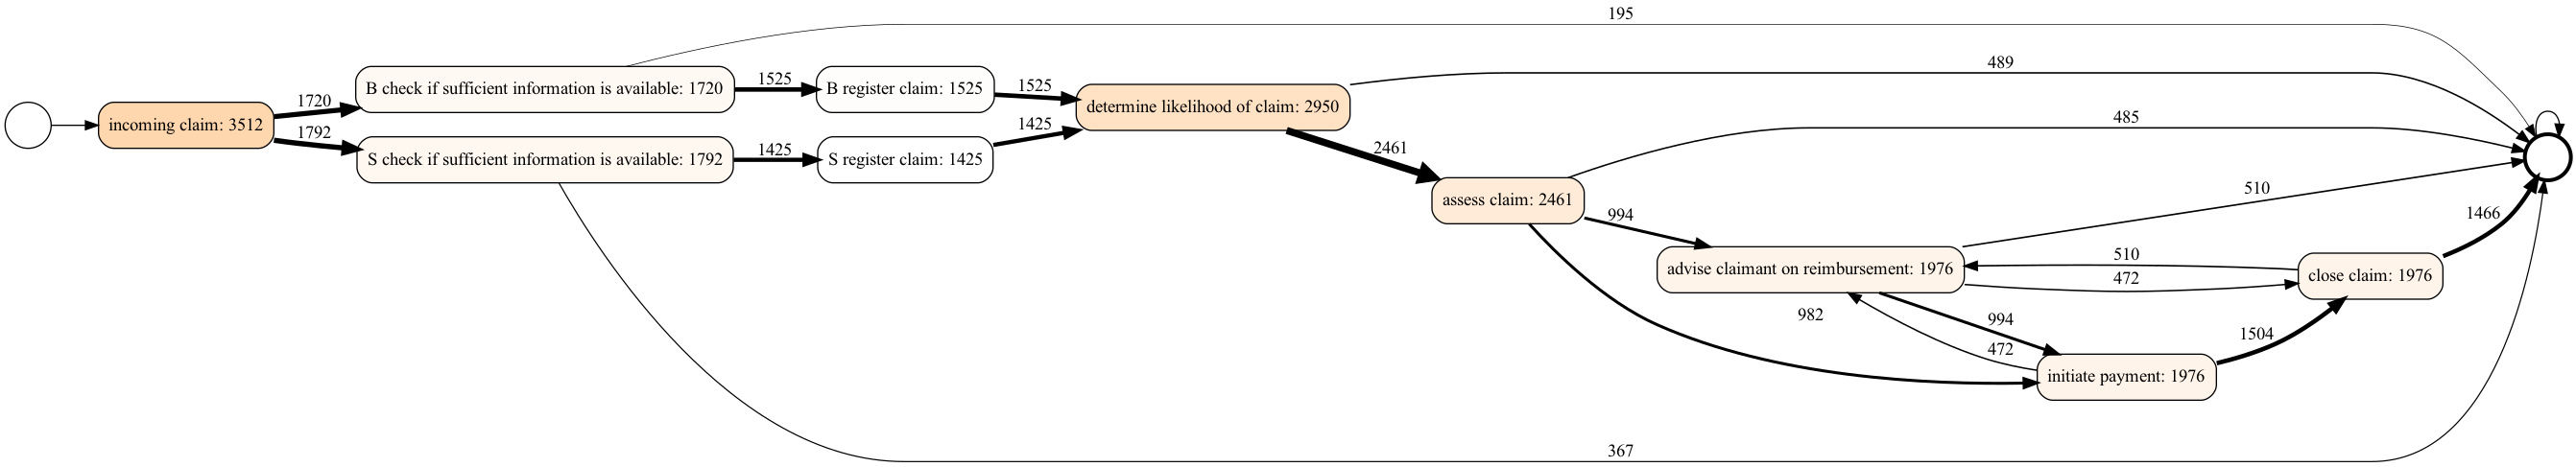

In [298]:
draw_graph_big(log_big_data)

PM4OY

Alpha Miner

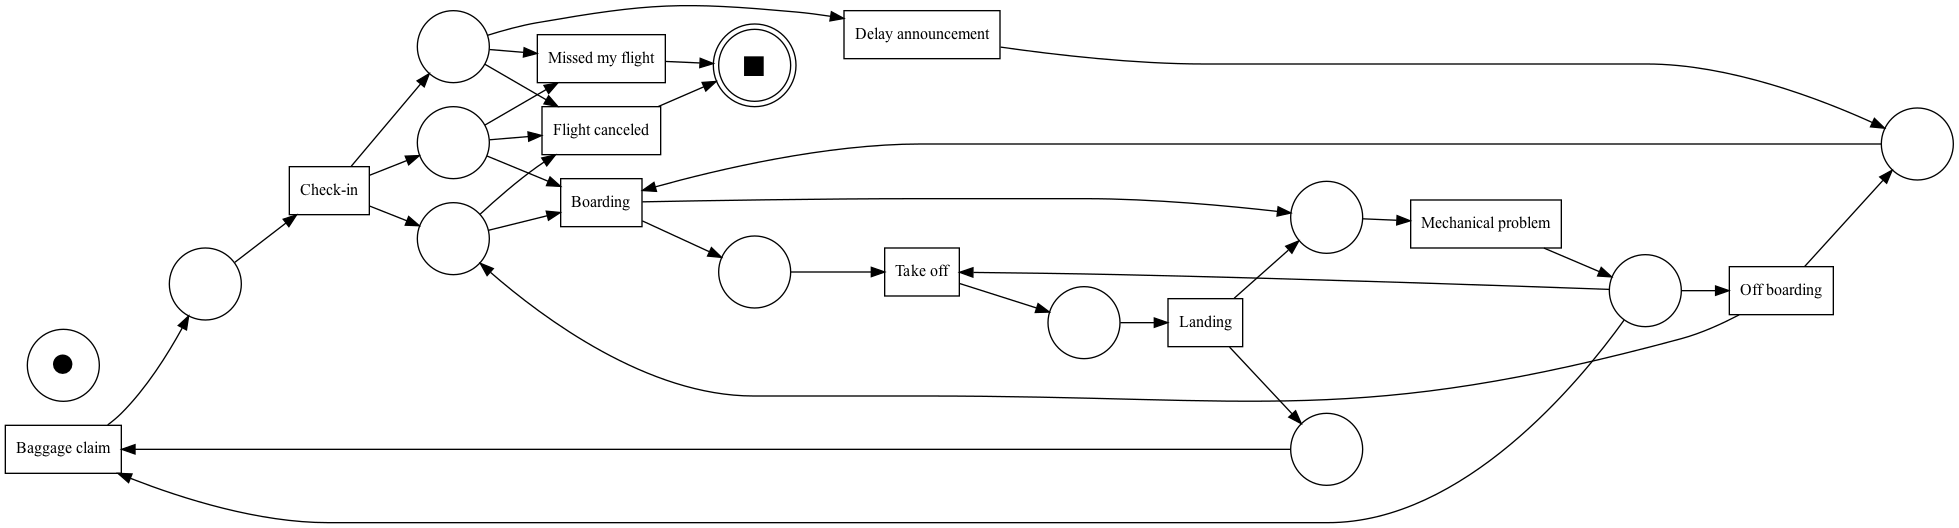

In [307]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log_small_data)

pm4py.view_petri_net(net, initial_marking, final_marking, format="png")

In [308]:
try:
    tree = pm4py.convert_to_process_tree(net, initial_marking, final_marking)
    pm4py.view_process_tree(tree)
except ValueError:
    print("Parsing of WF-net Failed")

Parsing of WF-net Failed


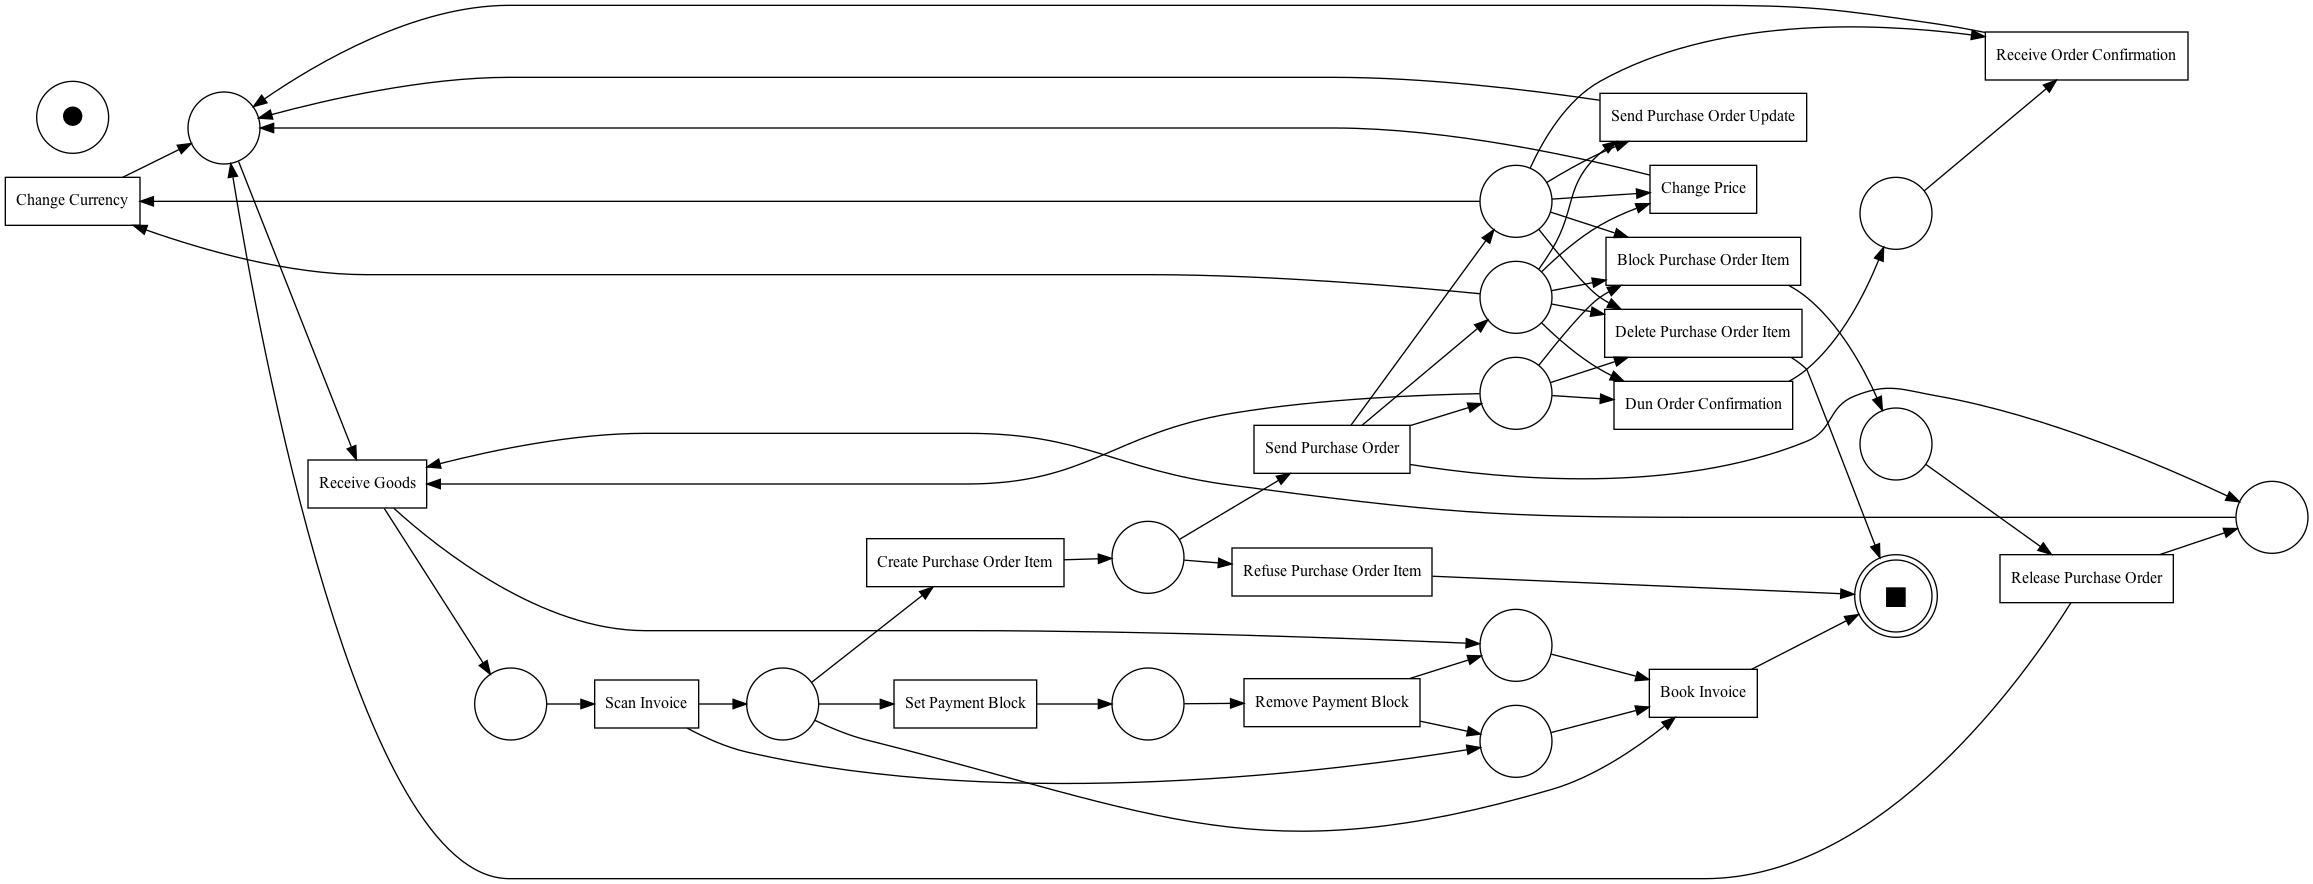

In [309]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log_medium_data)

pm4py.view_petri_net(net, initial_marking, final_marking, format="png")

In [310]:
try:
    tree = pm4py.convert_to_process_tree(net, initial_marking, final_marking)
    pm4py.view_process_tree(tree)
except ValueError:
    print("Parsing of WF-net Failed")

Parsing of WF-net Failed


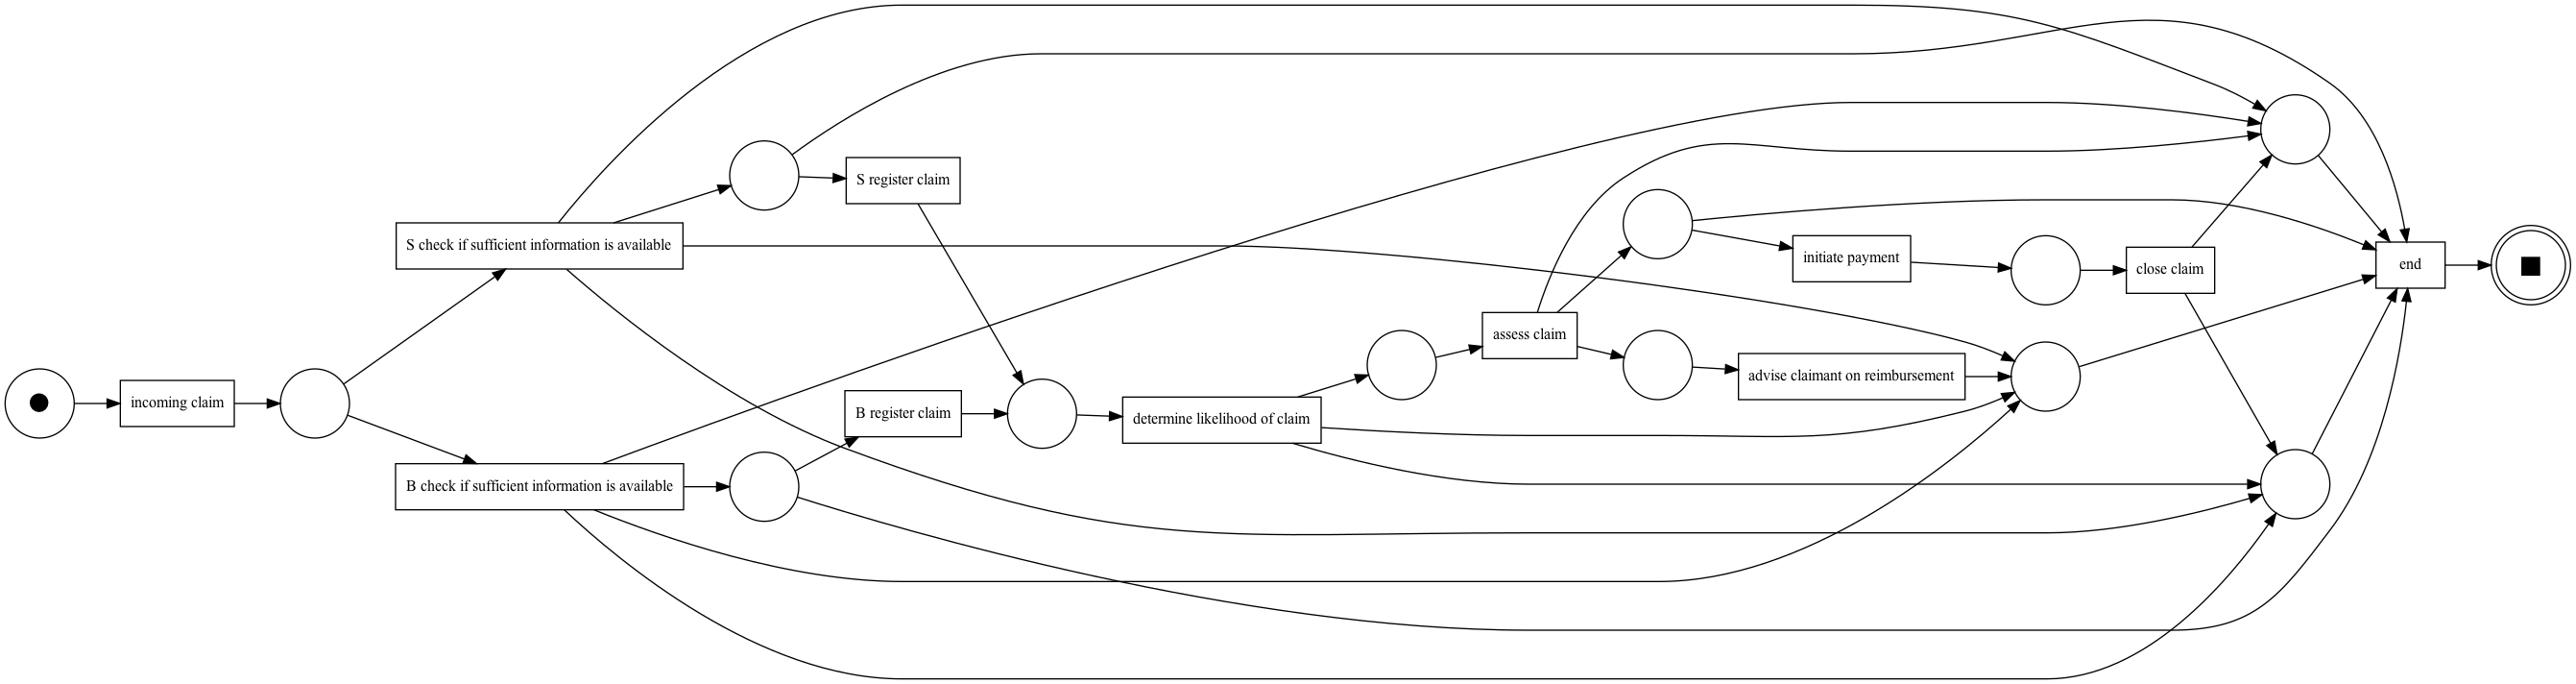

In [311]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log_big_data)

pm4py.view_petri_net(net, initial_marking, final_marking, format="png")

In [312]:
try:
    tree = pm4py.convert_to_process_tree(net, initial_marking, final_marking)
    pm4py.view_process_tree(tree)
except ValueError:
    print("Parsing of WF-net Failed")

Parsing of WF-net Failed


Inductive Miner

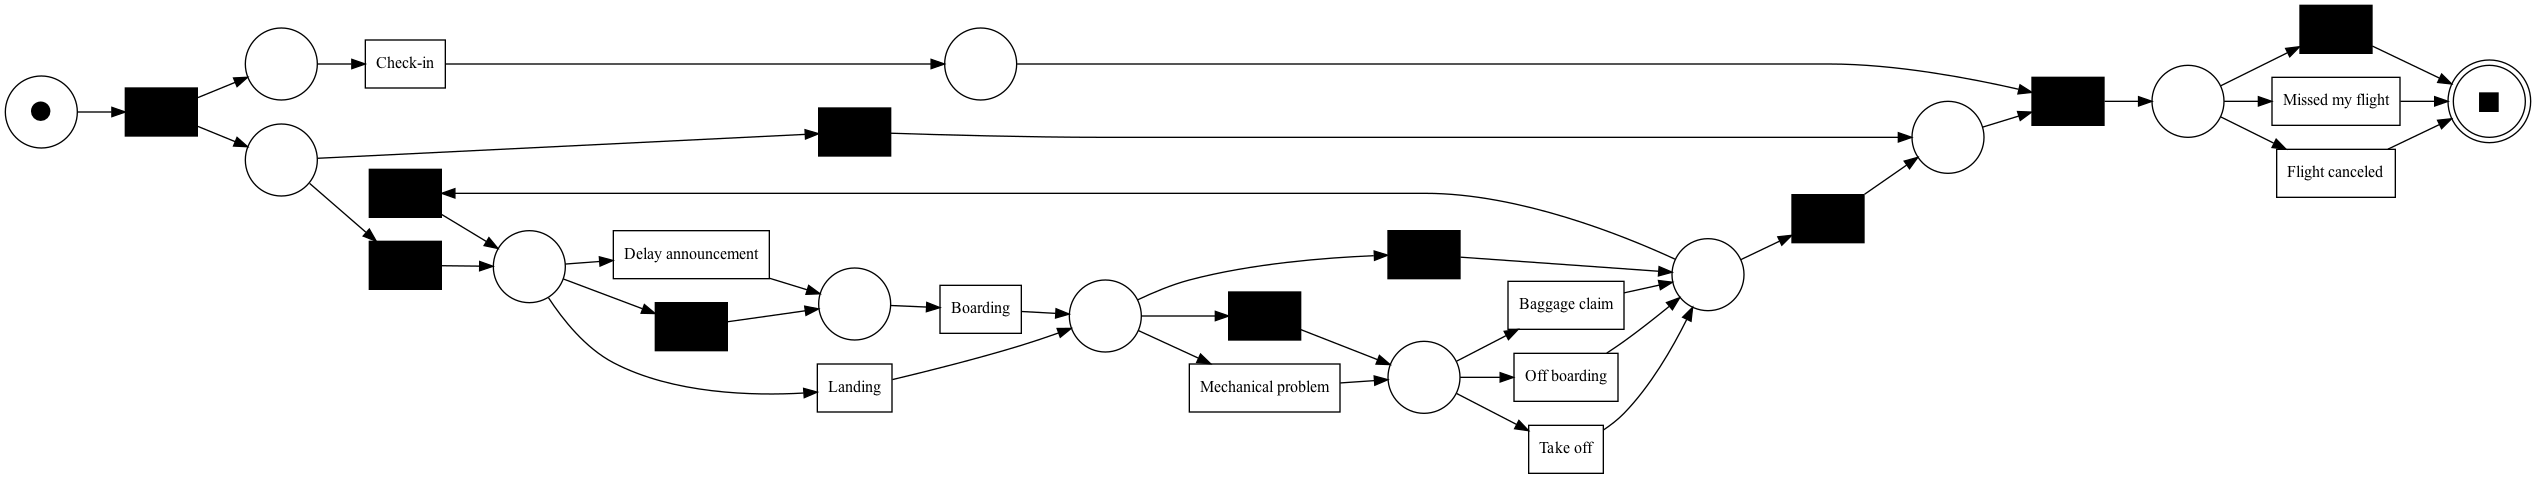

In [321]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log_small_data)

pm4py.view_petri_net(net, initial_marking, final_marking, format="png")

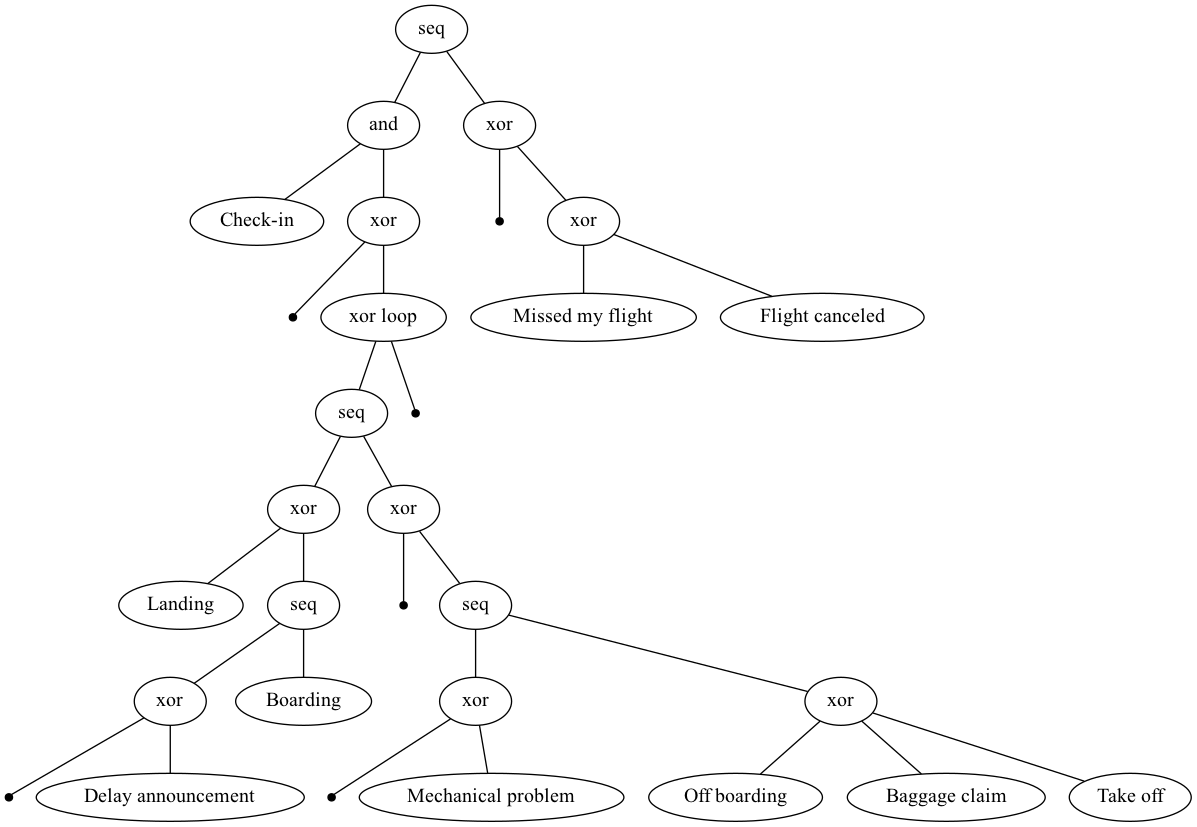

In [322]:
tree_small_extended = pm4py.discover_process_tree_inductive(log_small_data)

pm4py.view_process_tree(tree_small_extended)

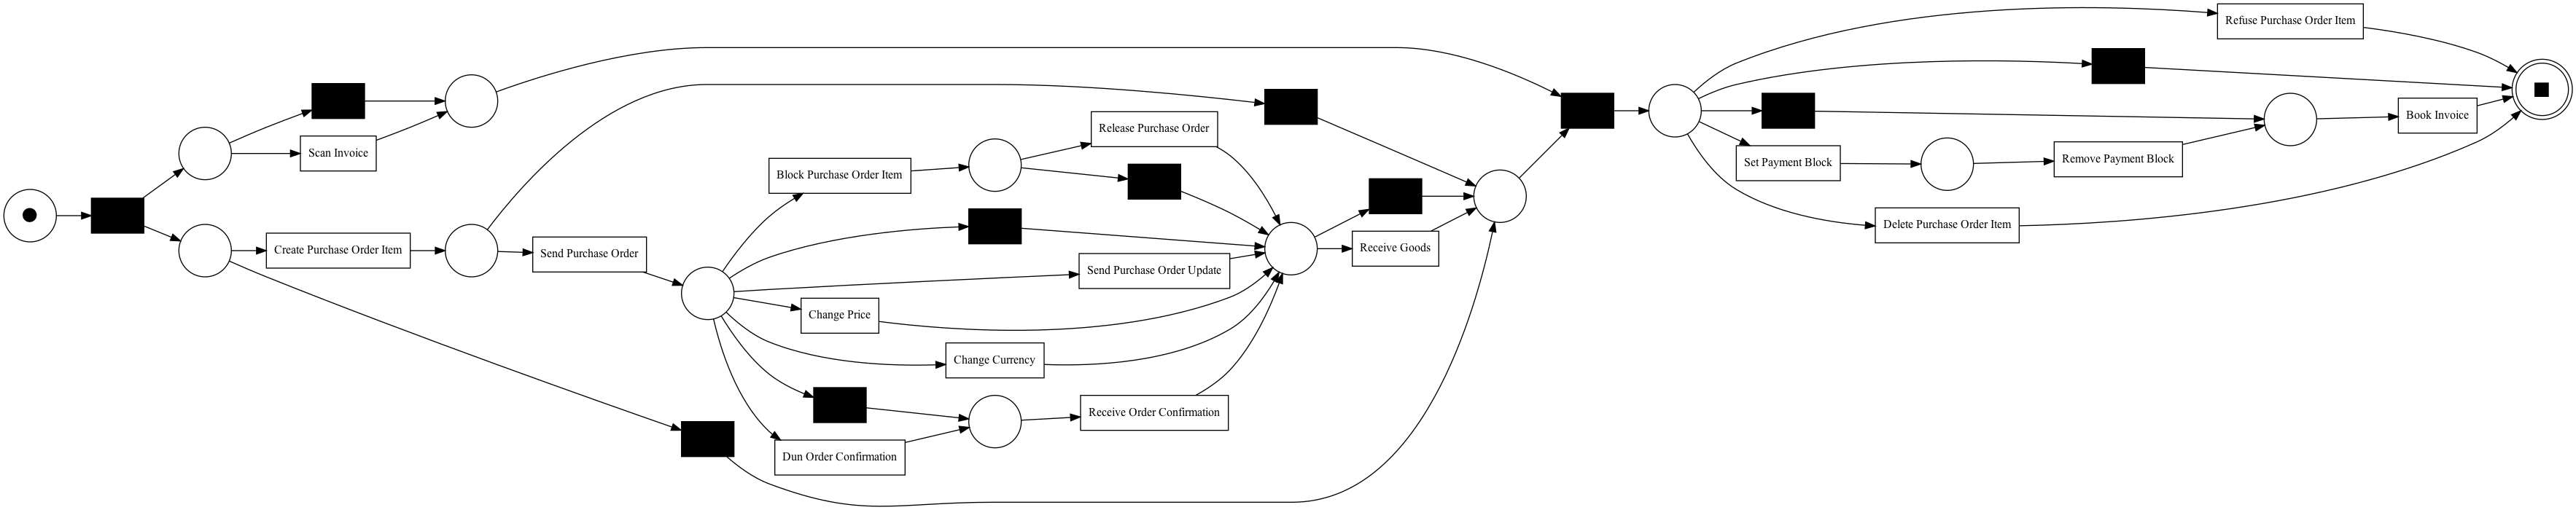

In [323]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log_medium_data)

pm4py.view_petri_net(net, initial_marking, final_marking, format="png")

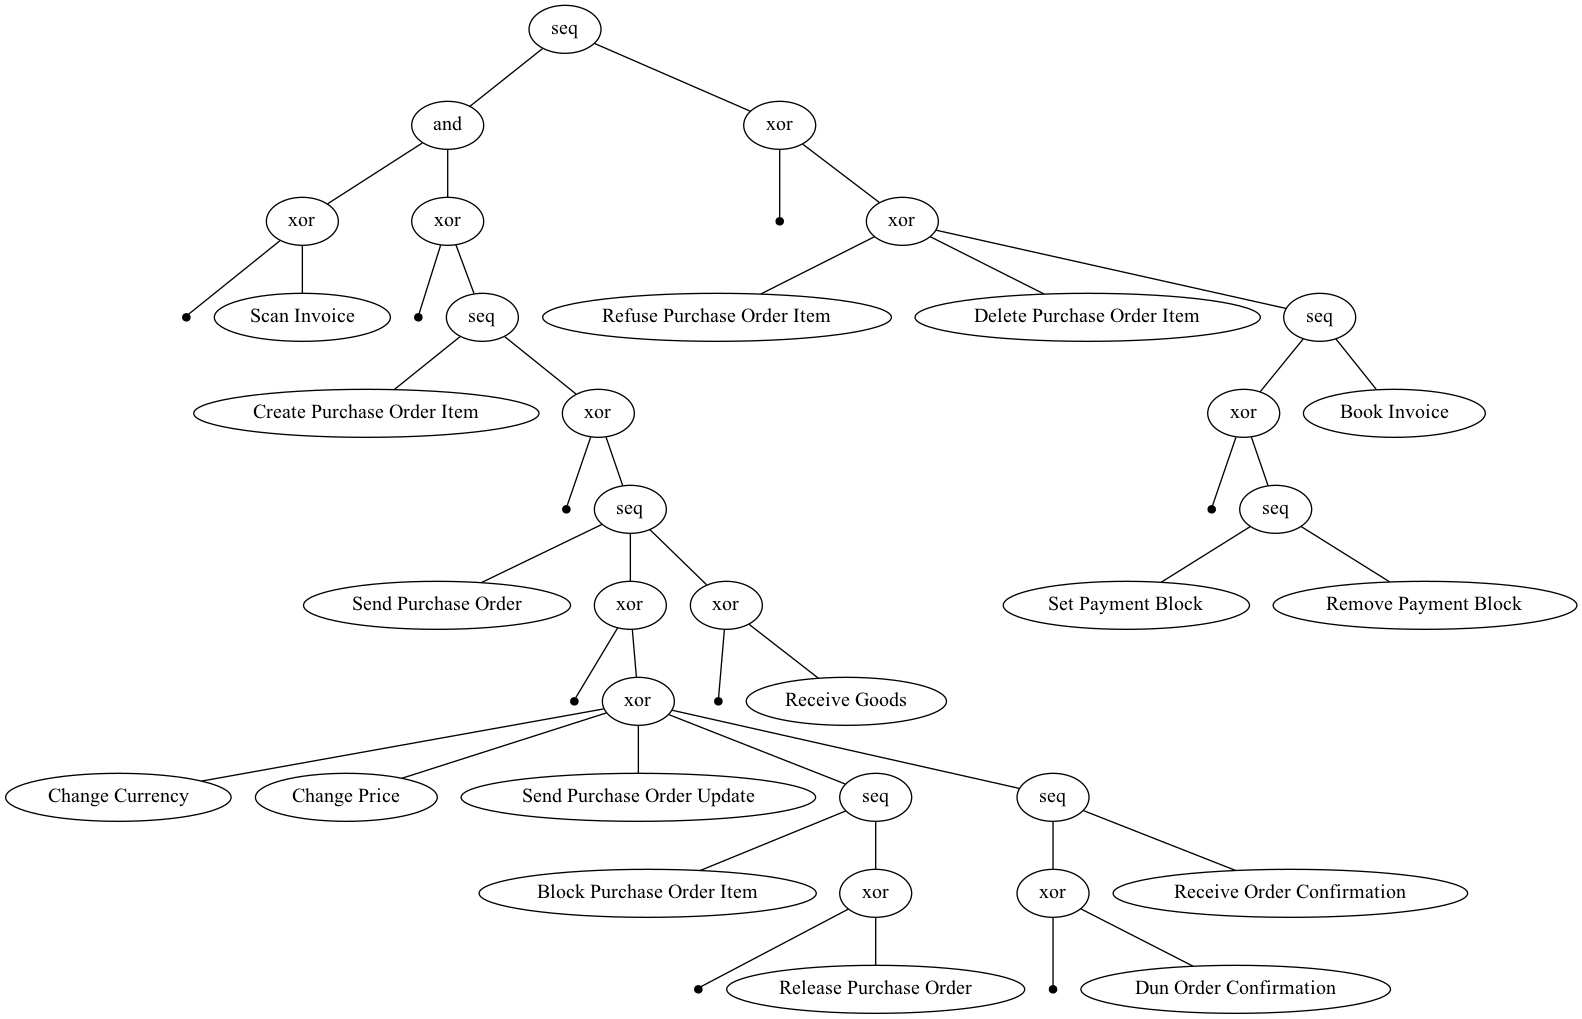

In [324]:
tree_medium_extended = pm4py.discover_process_tree_inductive(log_medium_data)

pm4py.view_process_tree(tree_medium_extended)

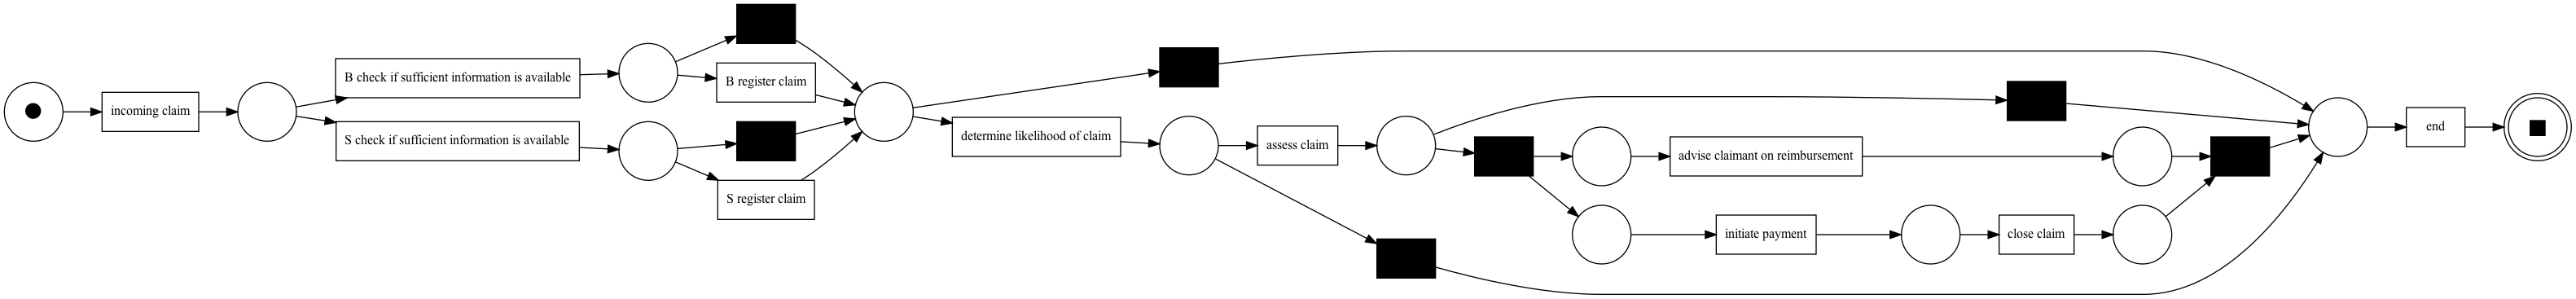

In [325]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log_big_data)

pm4py.view_petri_net(net, initial_marking, final_marking, format="png")

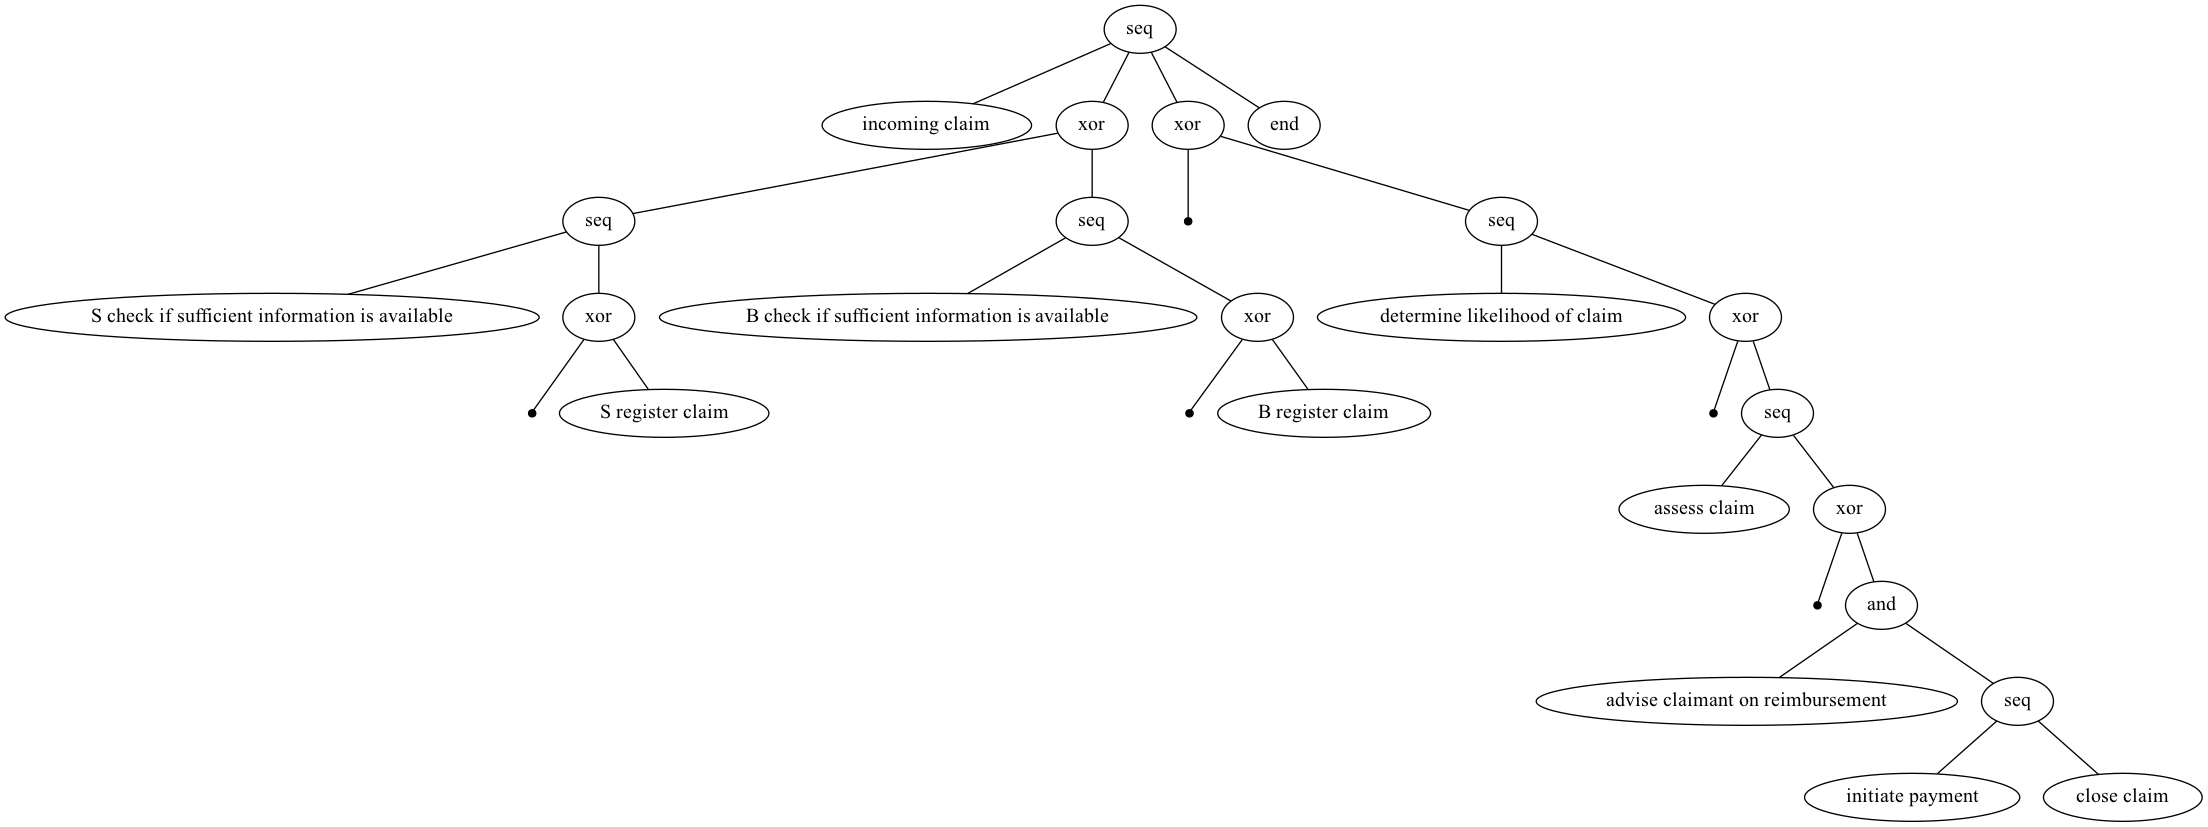

In [326]:
tree_big_extended = pm4py.discover_process_tree_inductive(log_big_data)

pm4py.view_process_tree(tree_big_extended)

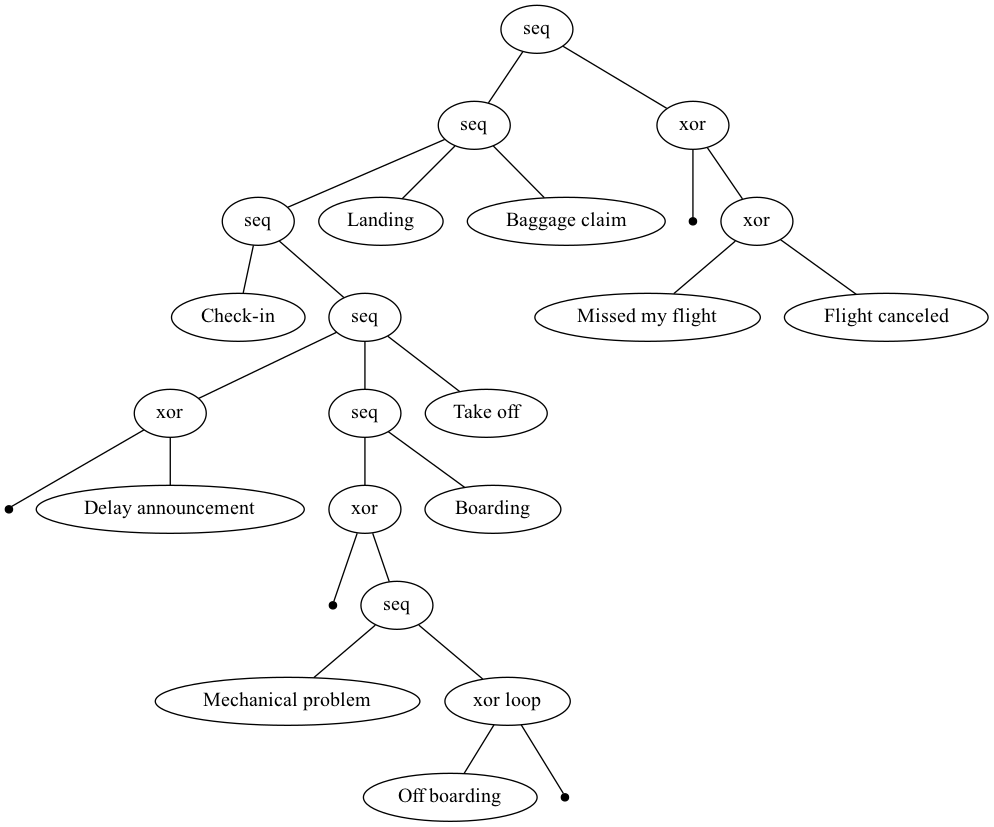

In [329]:
tree_small_extended_1 = pm4py.discover_process_tree_inductive(log_small_data, 0.5)

pm4py.view_process_tree(tree_small_extended_1)

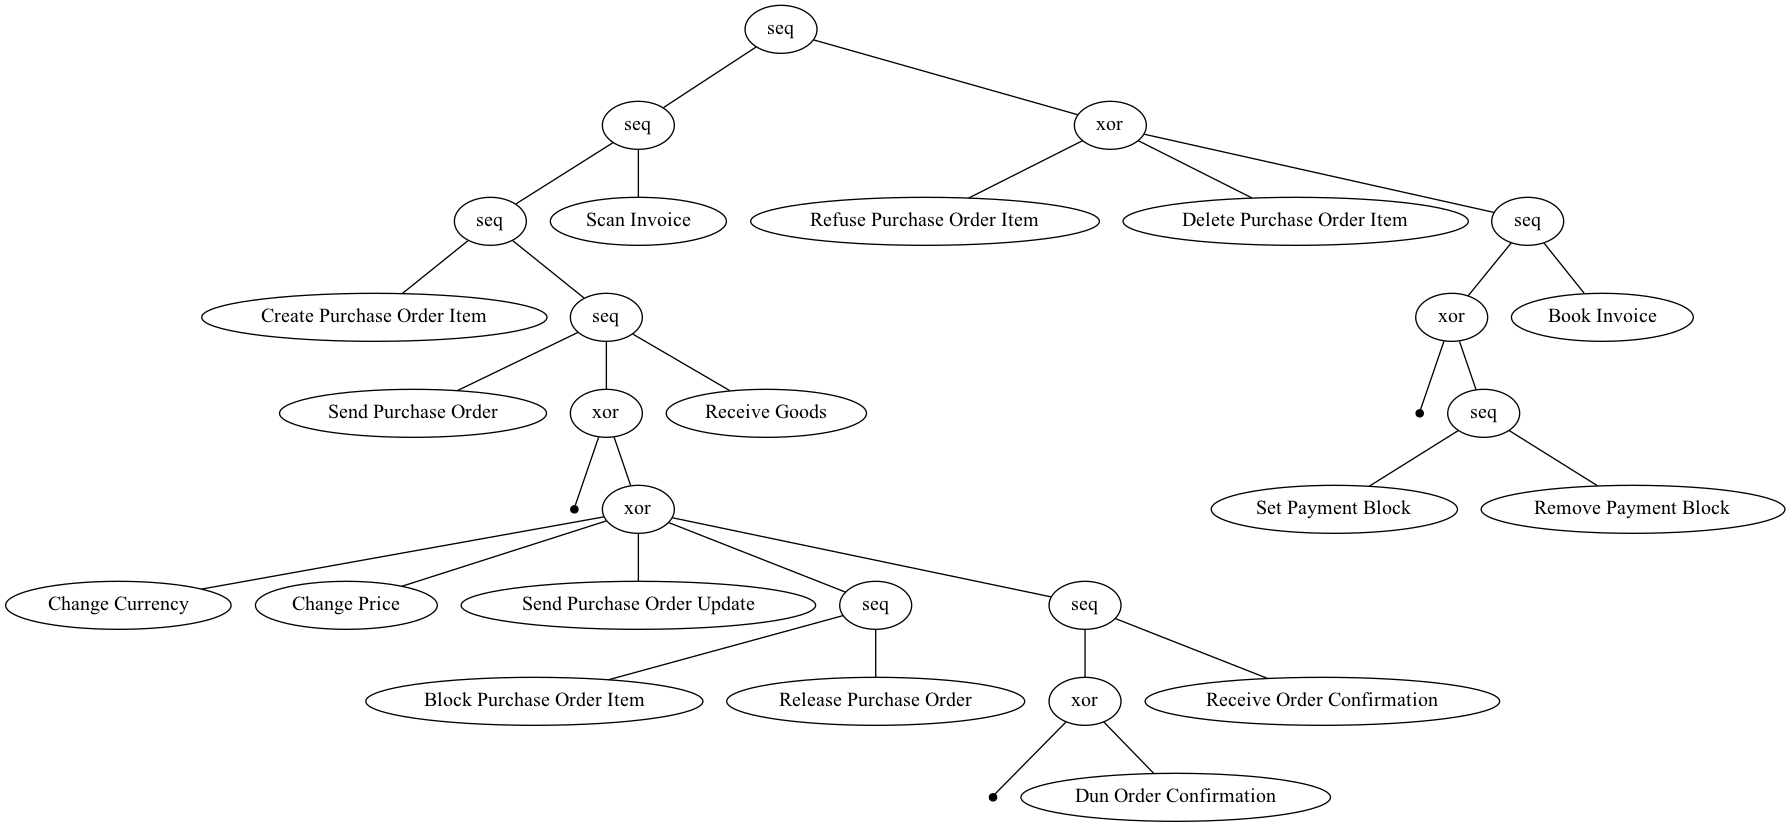

In [330]:
tree_medium_extended_1 = pm4py.discover_process_tree_inductive(log_medium_data, 0.5)

pm4py.view_process_tree(tree_medium_extended_1)

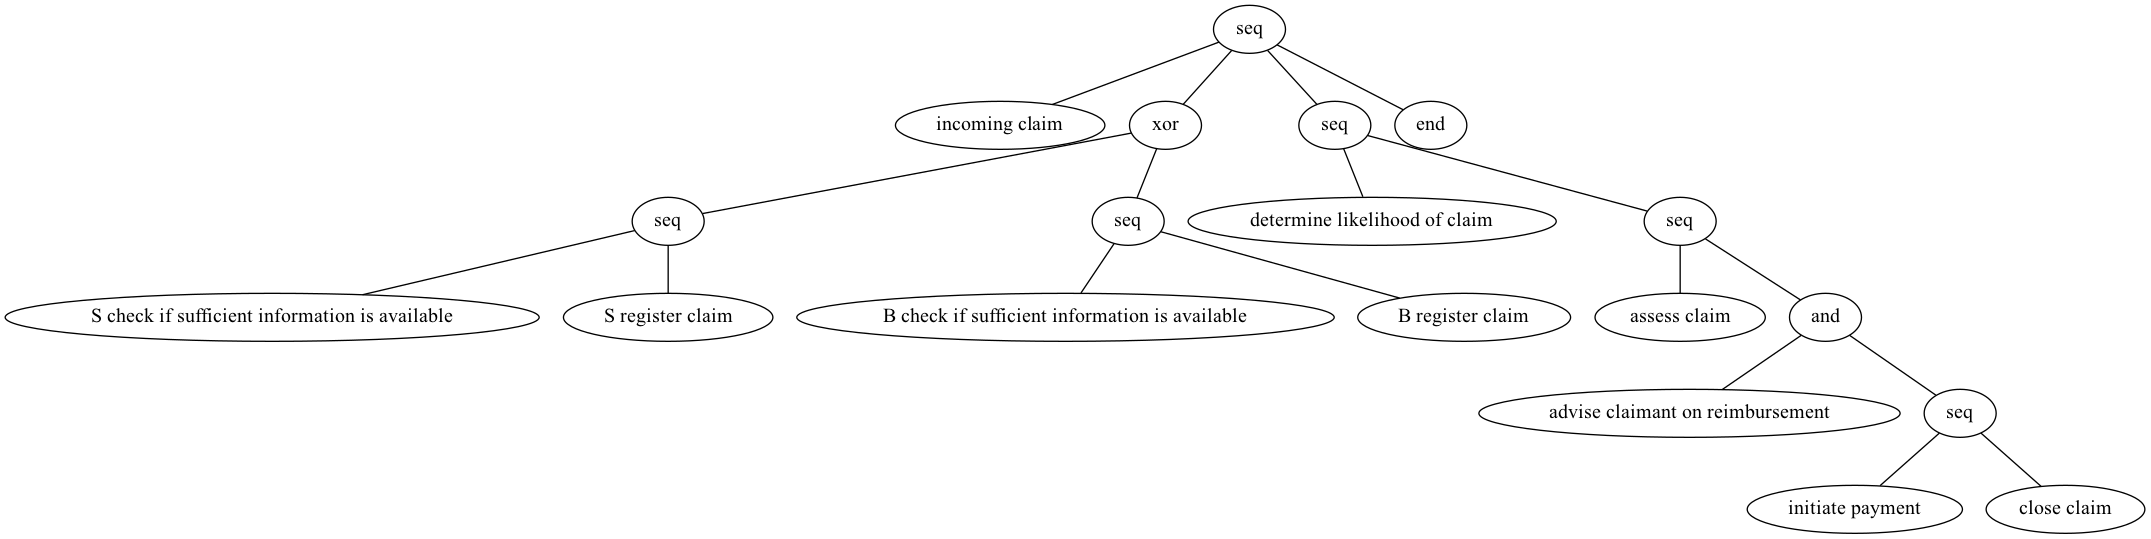

In [331]:
tree_big_extended_1 = pm4py.discover_process_tree_inductive(log_big_data, 0.5)

pm4py.view_process_tree(tree_big_extended_1)

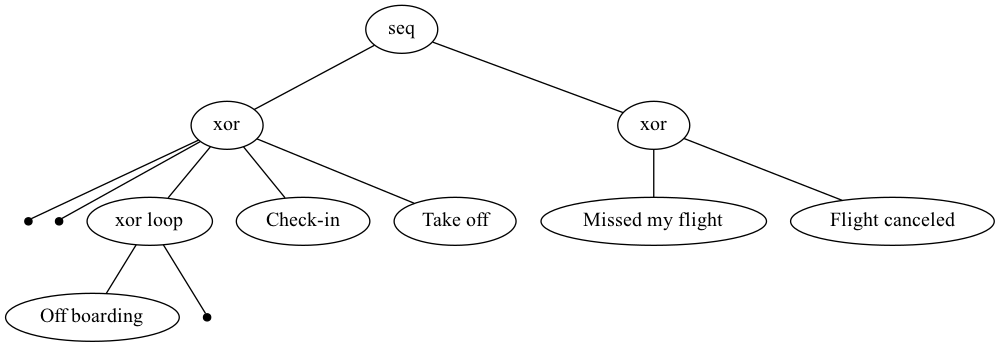

In [334]:
tree_small_extended_2 = pm4py.discover_process_tree_inductive(log_small_data, 1)

pm4py.view_process_tree(tree_small_extended_2)

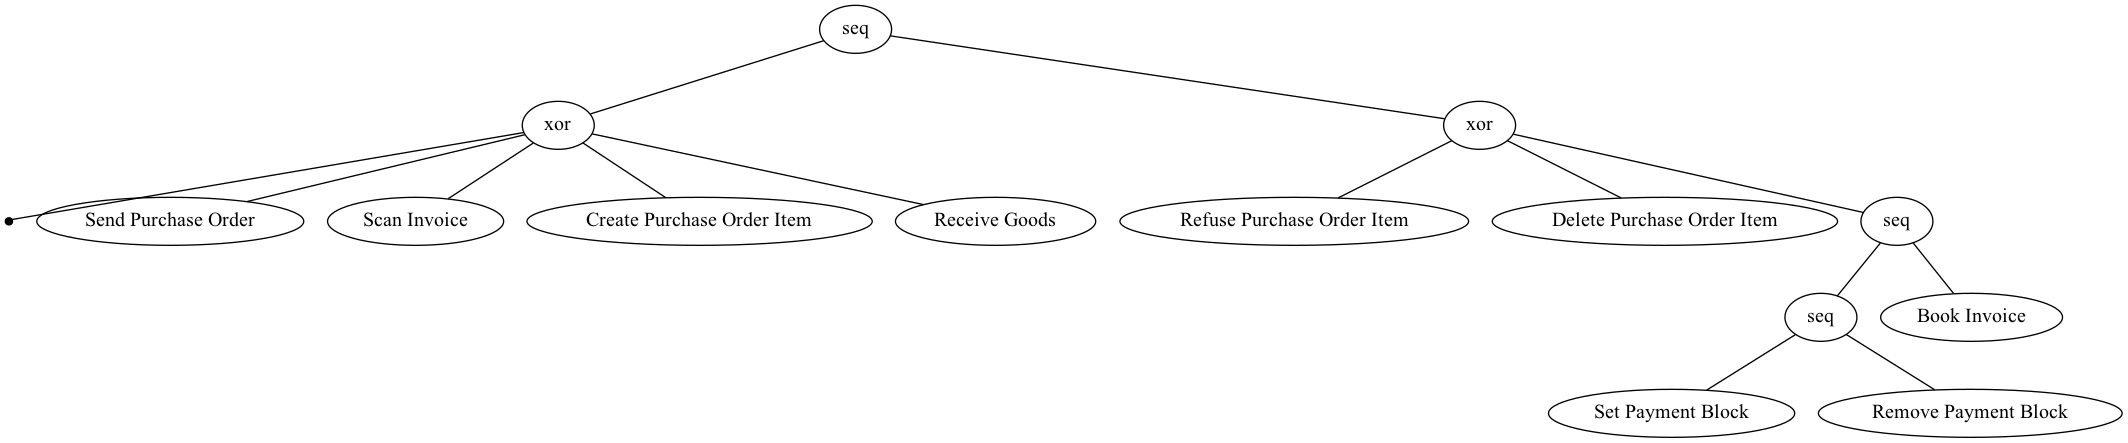

In [335]:
tree_medium_extended_2 = pm4py.discover_process_tree_inductive(log_medium_data, 1)

pm4py.view_process_tree(tree_medium_extended_2)

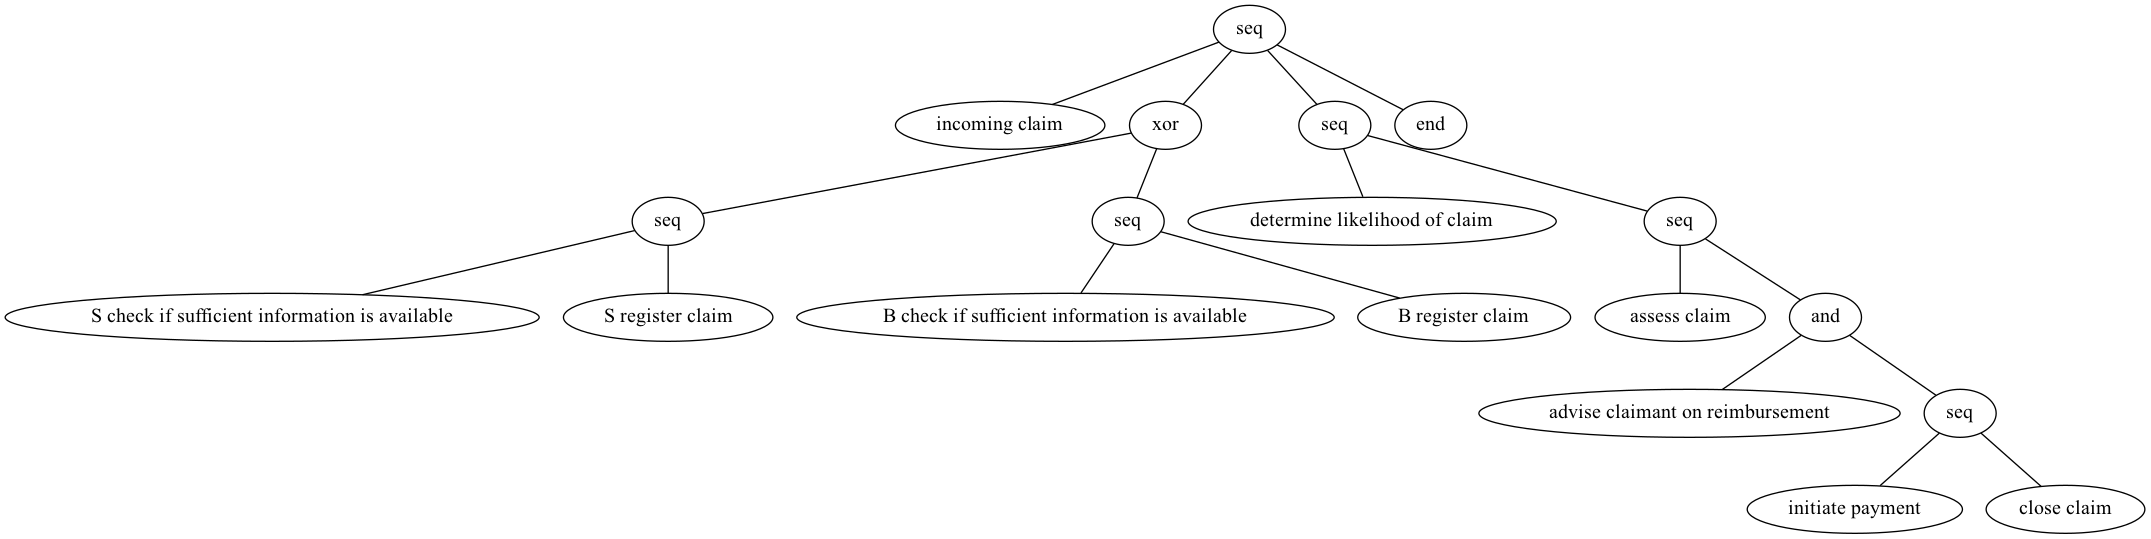

In [336]:
tree_big_extended_2 = pm4py.discover_process_tree_inductive(log_big_data, 1)

pm4py.view_process_tree(tree_big_extended_2)

Weight

In [345]:
W_Small = str(tree_small_extended)
print(W_Small)

->( +( 'Check-in', X( tau, *( ->( X( 'Landing', ->( X( tau, 'Delay announcement' ), 'Boarding' ) ), X( tau, ->( X( tau, 'Mechanical problem' ), X( 'Baggage claim', 'Take off', 'Off boarding' ) ) ) ), tau ) ) ), X( tau, X( 'Missed my flight', 'Flight canceled' ) ) )


In [346]:
W_Small1= str(tree_small_extended_1)
print(W_Small1)

->( ->( ->( 'Check-in', ->( X( tau, 'Delay announcement' ), ->( X( tau, ->( 'Mechanical problem', *( 'Off boarding', tau ) ) ), 'Boarding' ), 'Take off' ) ), 'Landing', 'Baggage claim' ), X( tau, X( 'Missed my flight', 'Flight canceled' ) ) )


In [347]:
W_Small2 = str(tree_small_extended_2)
print(W_Small2)

->( X( 'Check-in', tau, *( 'Off boarding', tau ), tau, 'Take off' ), X( 'Missed my flight', 'Flight canceled' ) )


In [348]:
W_Medium = str(tree_medium_extended)
print(W_Medium)

->( +( X( tau, 'Scan Invoice' ), X( tau, ->( 'Create Purchase Order Item', X( tau, ->( 'Send Purchase Order', X( tau, X( ->( 'Block Purchase Order Item', X( tau, 'Release Purchase Order' ) ), 'Send Purchase Order Update', ->( X( tau, 'Dun Order Confirmation' ), 'Receive Order Confirmation' ), 'Change Price', 'Change Currency' ) ), X( tau, 'Receive Goods' ) ) ) ) ) ), X( tau, X( 'Delete Purchase Order Item', ->( X( tau, ->( 'Set Payment Block', 'Remove Payment Block' ) ), 'Book Invoice' ), 'Refuse Purchase Order Item' ) ) )


In [349]:
W_Medium1 = str(tree_medium_extended_1)
print(W_Medium1)

->( ->( ->( 'Create Purchase Order Item', ->( 'Send Purchase Order', X( tau, X( ->( 'Block Purchase Order Item', 'Release Purchase Order' ), 'Send Purchase Order Update', ->( X( tau, 'Dun Order Confirmation' ), 'Receive Order Confirmation' ), 'Change Price', 'Change Currency' ) ), 'Receive Goods' ) ), 'Scan Invoice' ), X( 'Delete Purchase Order Item', ->( X( tau, ->( 'Set Payment Block', 'Remove Payment Block' ) ), 'Book Invoice' ), 'Refuse Purchase Order Item' ) )


In [350]:
W_Medium2 = str(tree_medium_extended_2)
print(W_Medium2)

->( X( tau, 'Create Purchase Order Item', 'Scan Invoice', 'Send Purchase Order', 'Receive Goods' ), X( 'Delete Purchase Order Item', ->( ->( 'Set Payment Block', 'Remove Payment Block' ), 'Book Invoice' ), 'Refuse Purchase Order Item' ) )


In [351]:
W_Big = str(tree_big_extended)
print(W_Big)

->( 'incoming claim', X( ->( 'B check if sufficient information is available', X( tau, 'B register claim' ) ), ->( 'S check if sufficient information is available', X( tau, 'S register claim' ) ) ), X( tau, ->( 'determine likelihood of claim', X( tau, ->( 'assess claim', X( tau, +( 'advise claimant on reimbursement', ->( 'initiate payment', 'close claim' ) ) ) ) ) ) ), 'end' )


In [352]:
W_Big1 = str(tree_big_extended_1)
print(W_Big1)

->( 'incoming claim', X( ->( 'B check if sufficient information is available', 'B register claim' ), ->( 'S check if sufficient information is available', 'S register claim' ) ), ->( 'determine likelihood of claim', ->( 'assess claim', +( 'advise claimant on reimbursement', ->( 'initiate payment', 'close claim' ) ) ) ), 'end' )


In [353]:
W_Big2 = str(tree_big_extended_2)
print(W_Big2)

->( 'incoming claim', X( ->( 'B check if sufficient information is available', 'B register claim' ), ->( 'S check if sufficient information is available', 'S register claim' ) ), ->( 'determine likelihood of claim', ->( 'assess claim', +( 'advise claimant on reimbursement', ->( 'initiate payment', 'close claim' ) ) ) ), 'end' )


Process Tree Adapter

In [354]:
class ProcessTreeAdapter:

    @staticmethod
    def remove_brackets_between_single_quotes(expression):
        pattern = r"'(.*?)'"
        matches = re.findall(pattern, expression)

        for match in matches:
            replaced = match.replace('(', '').replace(')', '')
            expression = expression.replace(f"'{match}'", f"'{replaced}'")
        return expression

    @staticmethod
    def label_expressions(expression: str) -> str:
        labelled_expression = ""
        label_number = 0
        for c in expression:
            if c == '(':
                label_number += 1
                labelled_expression += f"({label_number}]"
            elif c == ')':
                labelled_expression += f"[{label_number})"
                label_number -= 1
            else:
                labelled_expression += c
        return labelled_expression

    @staticmethod
    def extract_arguments_from_labelled_expression(labelled_expression):
        label_number_match = re.search(r"\[(\d+)\)$", labelled_expression)
        if not label_number_match:
            raise ValueError("Invalid labelled expression format.")

        pattern_label_number = int(label_number_match.group(1))
        trimmed_labelled_expression = labelled_expression[labelled_expression.index("]") + 1:-3]
        split = trimmed_labelled_expression.split(",")
        arguments = []
        brackets_counter = 0
        temp_arg = ""
        for s in split:
            brackets_counter += s.count('(')
            brackets_counter -= s.count(')')
            temp_arg += s + ","
            if brackets_counter == 0:
                temp_arg = temp_arg[:-1]
                arguments.append(temp_arg)
                temp_arg = ""
        return arguments, pattern_label_number

    @staticmethod
    def find_symbol(labelled_expression):
        pattern = r'^[^()]*'
        match = re.match(pattern, labelled_expression)
        if match:
            return re.sub(r'\s+', '', match.group())
        else:
            raise Exception("No match")

    @staticmethod
    def replace_spaces_with_underscore(tree):
        def replace_spaces(match):
            return re.sub(r'\s+', '_', match.group(0))

        text_with_underscore = re.sub(r"'(.*?)'", replace_spaces, tree)
        text_no_quotes = re.sub(r"'", '', text_with_underscore)

        return text_no_quotes

    @staticmethod
    def replace_symbol_with_name(labelled_pattern_expression, pattern_label_number, old_symbol, new_name):
        pattern = rf"{re.escape(old_symbol)}\(({pattern_label_number}\])"
        new_name = new_name + "(" + str(pattern_label_number) + "]"
        replaced_string = re.sub(pattern, new_name, labelled_pattern_expression)

        return replaced_string

    @staticmethod
    def get_highest_label(labelledExpression: str) -> int:
        maxLabel = -1
        active = False
        sb = ""
        for c in labelledExpression:
            if c == '(':
                active = True
            elif c == ']':
                if int(sb) > maxLabel:
                    maxLabel = int(sb)
                sb = ""
                active = False
            elif active:
                sb += c
        return maxLabel

In [357]:
W_Small = ProcessTreeAdapter.remove_brackets_between_single_quotes(W_Small)
W_Small1 = ProcessTreeAdapter.remove_brackets_between_single_quotes(W_Small1)
W_Small2 = ProcessTreeAdapter.remove_brackets_between_single_quotes(W_Small2)
print(W_Small)
print(W_Small1)
print(W_Small2)

->( +( 'Check-in', X( tau, *( ->( X( 'Landing', ->( X( tau, 'Delay announcement' ), 'Boarding' ) ), X( tau, ->( X( tau, 'Mechanical problem' ), X( 'Baggage claim', 'Take off', 'Off boarding' ) ) ) ), tau ) ) ), X( tau, X( 'Missed my flight', 'Flight canceled' ) ) )
->( ->( ->( 'Check-in', ->( X( tau, 'Delay announcement' ), ->( X( tau, ->( 'Mechanical problem', *( 'Off boarding', tau ) ) ), 'Boarding' ), 'Take off' ) ), 'Landing', 'Baggage claim' ), X( tau, X( 'Missed my flight', 'Flight canceled' ) ) )
->( X( 'Check-in', tau, *( 'Off boarding', tau ), tau, 'Take off' ), X( 'Missed my flight', 'Flight canceled' ) )


In [358]:
W_Medium = ProcessTreeAdapter.remove_brackets_between_single_quotes(W_Medium)
W_Medium1 = ProcessTreeAdapter.remove_brackets_between_single_quotes(W_Medium1)
W_Medium2 = ProcessTreeAdapter.remove_brackets_between_single_quotes(W_Medium)
print(W_Medium)
print(W_Medium1)
print(W_Medium2)

->( +( X( tau, 'Scan Invoice' ), X( tau, ->( 'Create Purchase Order Item', X( tau, ->( 'Send Purchase Order', X( tau, X( ->( 'Block Purchase Order Item', X( tau, 'Release Purchase Order' ) ), 'Send Purchase Order Update', ->( X( tau, 'Dun Order Confirmation' ), 'Receive Order Confirmation' ), 'Change Price', 'Change Currency' ) ), X( tau, 'Receive Goods' ) ) ) ) ) ), X( tau, X( 'Delete Purchase Order Item', ->( X( tau, ->( 'Set Payment Block', 'Remove Payment Block' ) ), 'Book Invoice' ), 'Refuse Purchase Order Item' ) ) )
->( ->( ->( 'Create Purchase Order Item', ->( 'Send Purchase Order', X( tau, X( ->( 'Block Purchase Order Item', 'Release Purchase Order' ), 'Send Purchase Order Update', ->( X( tau, 'Dun Order Confirmation' ), 'Receive Order Confirmation' ), 'Change Price', 'Change Currency' ) ), 'Receive Goods' ) ), 'Scan Invoice' ), X( 'Delete Purchase Order Item', ->( X( tau, ->( 'Set Payment Block', 'Remove Payment Block' ) ), 'Book Invoice' ), 'Refuse Purchase Order Item' ) )
-

In [359]:
W_Big = ProcessTreeAdapter.remove_brackets_between_single_quotes(W_Big)
W_Big1 = ProcessTreeAdapter.remove_brackets_between_single_quotes(W_Big1)
W_Big2 = ProcessTreeAdapter.remove_brackets_between_single_quotes(W_Big2)
print(W_Big)
print(W_Big1)
print(W_Big2)

->( 'incoming claim', X( ->( 'B check if sufficient information is available', X( tau, 'B register claim' ) ), ->( 'S check if sufficient information is available', X( tau, 'S register claim' ) ) ), X( tau, ->( 'determine likelihood of claim', X( tau, ->( 'assess claim', X( tau, +( 'advise claimant on reimbursement', ->( 'initiate payment', 'close claim' ) ) ) ) ) ) ), 'end' )
->( 'incoming claim', X( ->( 'B check if sufficient information is available', 'B register claim' ), ->( 'S check if sufficient information is available', 'S register claim' ) ), ->( 'determine likelihood of claim', ->( 'assess claim', +( 'advise claimant on reimbursement', ->( 'initiate payment', 'close claim' ) ) ) ), 'end' )
->( 'incoming claim', X( ->( 'B check if sufficient information is available', 'B register claim' ), ->( 'S check if sufficient information is available', 'S register claim' ) ), ->( 'determine likelihood of claim', ->( 'assess claim', +( 'advise claimant on reimbursement', ->( 'initiate p

In [362]:
W_Small = ProcessTreeAdapter.replace_spaces_with_underscore(W_Small)
W_Small = W_Small.replace("( ", "(").replace(") ", ")").replace(" )", ")").replace("->", ">")

W_Small1 = ProcessTreeAdapter.replace_spaces_with_underscore(W_Small1)
W_Small1 = W_Small1.replace("( ", "(").replace(") ", ")").replace(" )", ")").replace("->", ">")

W_Small2 = ProcessTreeAdapter.replace_spaces_with_underscore(W_Small2)
W_Small2 = W_Small2.replace("( ", "(").replace(") ", ")").replace(" )", ")").replace("->", ">")

print(W_Small)
print(W_Small1)
print(W_Small2)

>(+(Check-in, X(tau, *(>(X(Landing, >(X(tau, Delay_announcement), Boarding)), X(tau, >(X(tau, Mechanical_problem), X(Baggage_claim, Take_off, Off_boarding)))), tau))), X(tau, X(Missed_my_flight, Flight_canceled)))
>(>(>(Check-in, >(X(tau, Delay_announcement), >(X(tau, >(Mechanical_problem, *(Off_boarding, tau))), Boarding), Take_off)), Landing, Baggage_claim), X(tau, X(Missed_my_flight, Flight_canceled)))
>(X(Check-in, tau, *(Off_boarding, tau), tau, Take_off), X(Missed_my_flight, Flight_canceled))


In [363]:
W_Medium = ProcessTreeAdapter.replace_spaces_with_underscore(W_Medium)
W_Medium = W_Medium.replace("( ", "(").replace(") ", ")").replace(" )", ")").replace("->", ">")

W_Medium1 = ProcessTreeAdapter.replace_spaces_with_underscore(W_Medium1)
W_Medium1 = W_Medium1.replace("( ", "(").replace(") ", ")").replace(" )", ")").replace("->", ">")

W_Medium2 = ProcessTreeAdapter.replace_spaces_with_underscore(W_Medium2)
W_Medium2 = W_Medium2.replace("( ", "(").replace(") ", ")").replace(" )", ")").replace("->", ">")

print(W_Medium)
print(W_Medium1)
print(W_Medium2)

>(+(X(tau, Scan_Invoice), X(tau, >(Create_Purchase_Order_Item, X(tau, >(Send_Purchase_Order, X(tau, X(>(Block_Purchase_Order_Item, X(tau, Release_Purchase_Order)), Send_Purchase_Order_Update, >(X(tau, Dun_Order_Confirmation), Receive_Order_Confirmation), Change_Price, Change_Currency)), X(tau, Receive_Goods)))))), X(tau, X(Delete_Purchase_Order_Item, >(X(tau, >(Set_Payment_Block, Remove_Payment_Block)), Book_Invoice), Refuse_Purchase_Order_Item)))
>(>(>(Create_Purchase_Order_Item, >(Send_Purchase_Order, X(tau, X(>(Block_Purchase_Order_Item, Release_Purchase_Order), Send_Purchase_Order_Update, >(X(tau, Dun_Order_Confirmation), Receive_Order_Confirmation), Change_Price, Change_Currency)), Receive_Goods)), Scan_Invoice), X(Delete_Purchase_Order_Item, >(X(tau, >(Set_Payment_Block, Remove_Payment_Block)), Book_Invoice), Refuse_Purchase_Order_Item))
>(+(X(tau, Scan_Invoice), X(tau, >(Create_Purchase_Order_Item, X(tau, >(Send_Purchase_Order, X(tau, X(>(Block_Purchase_Order_Item, X(tau, Releas

In [364]:
W_Big = ProcessTreeAdapter.replace_spaces_with_underscore(W_Big)
W_Big = W_Big.replace("( ", "(").replace(") ", ")").replace(" )", ")").replace("->", ">")

W_Big1 = ProcessTreeAdapter.replace_spaces_with_underscore(W_Big1)
W_Big1 = W_Big1.replace("( ", "(").replace(") ", ")").replace(" )", ")").replace("->", ">")

W_Big2 = ProcessTreeAdapter.replace_spaces_with_underscore(W_Big2)
W_Big2 = W_Big2.replace("( ", "(").replace(") ", ")").replace(" )", ")").replace("->", ">")

print(W_Big)
print(W_Big1)
print(W_Big2)

>(incoming_claim, X(>(B_check_if_sufficient_information_is_available, X(tau, B_register_claim)), >(S_check_if_sufficient_information_is_available, X(tau, S_register_claim))), X(tau, >(determine_likelihood_of_claim, X(tau, >(assess_claim, X(tau, +(advise_claimant_on_reimbursement, >(initiate_payment, close_claim))))))), end)
>(incoming_claim, X(>(B_check_if_sufficient_information_is_available, B_register_claim), >(S_check_if_sufficient_information_is_available, S_register_claim)), >(determine_likelihood_of_claim, >(assess_claim, +(advise_claimant_on_reimbursement, >(initiate_payment, close_claim)))), end)
>(incoming_claim, X(>(B_check_if_sufficient_information_is_available, B_register_claim), >(S_check_if_sufficient_information_is_available, S_register_claim)), >(determine_likelihood_of_claim, >(assess_claim, +(advise_claimant_on_reimbursement, >(initiate_payment, close_claim)))), end)


In [367]:
labelled_pattern_expression_small = ProcessTreeAdapter.label_expressions(W_Small)
labelled_pattern_expression_small1 = ProcessTreeAdapter.label_expressions(W_Small1)
labelled_pattern_expression_small2 = ProcessTreeAdapter.label_expressions(W_Small2)
print(labelled_pattern_expression_small)
print(labelled_pattern_expression_small1)
print(labelled_pattern_expression_small2)

>(1]+(2]Check-in, X(3]tau, *(4]>(5]X(6]Landing, >(7]X(8]tau, Delay_announcement[8), Boarding[7)[6), X(6]tau, >(7]X(8]tau, Mechanical_problem[8), X(8]Baggage_claim, Take_off, Off_boarding[8)[7)[6)[5), tau[4)[3)[2), X(2]tau, X(3]Missed_my_flight, Flight_canceled[3)[2)[1)
>(1]>(2]>(3]Check-in, >(4]X(5]tau, Delay_announcement[5), >(5]X(6]tau, >(7]Mechanical_problem, *(8]Off_boarding, tau[8)[7)[6), Boarding[5), Take_off[4)[3), Landing, Baggage_claim[2), X(2]tau, X(3]Missed_my_flight, Flight_canceled[3)[2)[1)
>(1]X(2]Check-in, tau, *(3]Off_boarding, tau[3), tau, Take_off[2), X(2]Missed_my_flight, Flight_canceled[2)[1)


In [368]:
labelled_pattern_expression_medium = ProcessTreeAdapter.label_expressions(W_Medium)
labelled_pattern_expression_medium1 = ProcessTreeAdapter.label_expressions(W_Medium1)
labelled_pattern_expression_medium2 = ProcessTreeAdapter.label_expressions(W_Medium2)
print(labelled_pattern_expression_medium)
print(labelled_pattern_expression_medium1)
print(labelled_pattern_expression_medium2)

>(1]+(2]X(3]tau, Scan_Invoice[3), X(3]tau, >(4]Create_Purchase_Order_Item, X(5]tau, >(6]Send_Purchase_Order, X(7]tau, X(8]>(9]Block_Purchase_Order_Item, X(10]tau, Release_Purchase_Order[10)[9), Send_Purchase_Order_Update, >(9]X(10]tau, Dun_Order_Confirmation[10), Receive_Order_Confirmation[9), Change_Price, Change_Currency[8)[7), X(7]tau, Receive_Goods[7)[6)[5)[4)[3)[2), X(2]tau, X(3]Delete_Purchase_Order_Item, >(4]X(5]tau, >(6]Set_Payment_Block, Remove_Payment_Block[6)[5), Book_Invoice[4), Refuse_Purchase_Order_Item[3)[2)[1)
>(1]>(2]>(3]Create_Purchase_Order_Item, >(4]Send_Purchase_Order, X(5]tau, X(6]>(7]Block_Purchase_Order_Item, Release_Purchase_Order[7), Send_Purchase_Order_Update, >(7]X(8]tau, Dun_Order_Confirmation[8), Receive_Order_Confirmation[7), Change_Price, Change_Currency[6)[5), Receive_Goods[4)[3), Scan_Invoice[2), X(2]Delete_Purchase_Order_Item, >(3]X(4]tau, >(5]Set_Payment_Block, Remove_Payment_Block[5)[4), Book_Invoice[3), Refuse_Purchase_Order_Item[2)[1)
>(1]+(2]X(3]

In [369]:
labelled_pattern_expression_big = ProcessTreeAdapter.label_expressions(W_Big)
labelled_pattern_expression_big1 = ProcessTreeAdapter.label_expressions(W_Big1)
labelled_pattern_expression_big2 = ProcessTreeAdapter.label_expressions(W_Big2)
print(labelled_pattern_expression_big)
print(labelled_pattern_expression_big1)
print(labelled_pattern_expression_big2)

>(1]incoming_claim, X(2]>(3]B_check_if_sufficient_information_is_available, X(4]tau, B_register_claim[4)[3), >(3]S_check_if_sufficient_information_is_available, X(4]tau, S_register_claim[4)[3)[2), X(2]tau, >(3]determine_likelihood_of_claim, X(4]tau, >(5]assess_claim, X(6]tau, +(7]advise_claimant_on_reimbursement, >(8]initiate_payment, close_claim[8)[7)[6)[5)[4)[3)[2), end[1)
>(1]incoming_claim, X(2]>(3]B_check_if_sufficient_information_is_available, B_register_claim[3), >(3]S_check_if_sufficient_information_is_available, S_register_claim[3)[2), >(2]determine_likelihood_of_claim, >(3]assess_claim, +(4]advise_claimant_on_reimbursement, >(5]initiate_payment, close_claim[5)[4)[3)[2), end[1)
>(1]incoming_claim, X(2]>(3]B_check_if_sufficient_information_is_available, B_register_claim[3), >(3]S_check_if_sufficient_information_is_available, S_register_claim[3)[2), >(2]determine_likelihood_of_claim, >(3]assess_claim, +(4]advise_claimant_on_reimbursement, >(5]initiate_payment, close_claim[5)[4)[

Zmiana etykiet drzewa procesu

In [370]:
class Sequence:
    @staticmethod
    def change_symbol_into_name(labelled_expression):
        pattern_symbol = '>'
        pattern_name = 'Seq'
        if len(labelled_expression) == 2:
            pattern_name = 'Seq2'
        elif len(labelled_expression) == 3:
            pattern_name = 'Seq3'
        elif len(labelled_expression) == 4:
            pattern_name = 'Seq4'
        elif len(labelled_expression) == 5:
            pattern_name = 'Seq5'
        else:
            raise Exception("pattern does not exist")
        return pattern_name

class Loop:
    @staticmethod
    def change_symbol_into_name(labelled_expression, pattern_label_number):
        pattern_symbol = '*'
        pattern_name = 'Loop'
        labelled_expression_to_replace = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        if len(labelled_expression) == 2:
            labelled_expression = ['l_s'] + labelled_expression
        else:
            raise Exception("pattern does not exist")
        new_labelled_expression = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        return pattern_name, labelled_expression_to_replace, new_labelled_expression

class ExclusiveChoice:
    @staticmethod
    def change_symbol_into_name(labelled_expression, pattern_label_number):
        pattern_symbol = 'X'
        pattern_name = 'Xor'
        labelled_expression_to_replace = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        if len(labelled_expression) == 2:
            pattern_name = 'Xor2'
            labelled_expression = ['x2_s'] + labelled_expression + ['x2_e']
        elif len(labelled_expression) == 3:
            pattern_name = 'Xor3'
            labelled_expression = ['x3_s'] + labelled_expression + ['x3_e']
        else:
            raise Exception("pattern does not exist")
        new_labelled_expression = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        return pattern_name, labelled_expression_to_replace, new_labelled_expression

class Parallelism:
    @staticmethod
    def change_symbol_into_name(labelled_expression, pattern_label_number):
        pattern_symbol = '+'
        pattern_name = 'And'
        labelled_expression_to_replace = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        if len(labelled_expression) == 2:
            pattern_name = 'And2'
            labelled_expression = ['a2_s'] + labelled_expression + ['a2_e']
        elif len(labelled_expression) == 3:
            pattern_name = 'And3'
            labelled_expression = ['a3_s'] + labelled_expression + ['a3_e']
        else:
            raise Exception("pattern does not exist")
        new_labelled_expression = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        return pattern_name, labelled_expression_to_replace, new_labelled_expression

Pattern Expression Generator

In [371]:
class PatternExpressionGenerator:
    def __init__(self, converted_expression):
        self.converted_expression = converted_expression

    def add_approved_workflow_patterns(self, expression):
        if expression == None or isinstance(expression , list):
            return

        symbol = ProcessTreeAdapter.find_symbol(expression)
        pattern = r'>|X|\+|\*'
        matches = re.findall(pattern, expression)

        if (len(matches) != 0):
            arguments = ProcessTreeAdapter.extract_arguments_from_labelled_expression(expression)
            expression = arguments[0]
            pattern_label_number = arguments[1]
            if symbol == '>':
                new_name = Sequence.change_symbol_into_name(expression)
                self.converted_expression = ProcessTreeAdapter.replace_symbol_with_name(self.converted_expression, pattern_label_number, symbol, new_name)
            elif symbol == '*':
                new_name = Loop.change_symbol_into_name(expression, pattern_label_number)
                self.converted_expression = ProcessTreeAdapter.replace_symbol_with_name(self.converted_expression, pattern_label_number, symbol, new_name[0])
                expression_to_replace = self.converted_expression
                self.converted_expression = expression_to_replace.replace(new_name[1], new_name[2])
            elif symbol == '+':
                new_name = Parallelism.change_symbol_into_name(expression, pattern_label_number)
                self.converted_expression = ProcessTreeAdapter.replace_symbol_with_name(self.converted_expression, pattern_label_number, symbol, new_name[0])

                expression_to_replace = self.converted_expression
                self.converted_expression = expression_to_replace.replace(new_name[1], new_name[2])
            elif symbol == 'X':
                new_name = ExclusiveChoice.change_symbol_into_name(expression, pattern_label_number)
                self.converted_expression = ProcessTreeAdapter.replace_symbol_with_name(self.converted_expression, pattern_label_number, symbol, new_name[0])
                expression_to_replace = self.converted_expression
                self.converted_expression = expression_to_replace.replace(new_name[1], new_name[2])
            else:
                raise Exception("pattern does not exist")
        return expression

    def get_converted_expression(self):
        return self.converted_expression

In [372]:
def process_patterns(pattern_list, instance):
    new_pattern_list = []
    for pattern in pattern_list:
        new_pattern = instance.add_approved_workflow_patterns(pattern)
        if isinstance(new_pattern, list):
            new_pattern = process_patterns(new_pattern, instance)
        new_pattern_list.append(new_pattern)
    return new_pattern_list

def recursive_process(pattern_list, instance, depth):
    if depth <= 0:
        return pattern_list
    else:
        pattern_list = process_patterns(pattern_list, instance)
        return recursive_process(pattern_list, instance, depth - 1)

def get_pattern_expression(labelled_pattern_expression):
    pattern_list = []
    pattern_list.append(labelled_pattern_expression)
    pattern_expression_generator = PatternExpressionGenerator(labelled_pattern_expression)
    recursive_process(pattern_list, pattern_expression_generator, ProcessTreeAdapter.get_highest_label(labelled_pattern_expression))

    return pattern_expression_generator.get_converted_expression()


In [374]:
pattern_expression_small = get_pattern_expression(labelled_pattern_expression_small)
pattern_expression_small1 = get_pattern_expression(labelled_pattern_expression_small1)
print(pattern_expression_small)
print(pattern_expression_small1)

Seq2(1]And2(2]a2_s,Check-in, Xor2(3]x2_s,tau, Loop(4]l_s,Seq2(5]Xor2(6]x2_s,Landing, Seq2(7]Xor2(8]x2_s,tau, Delay_announcement,x2_e[8), Boarding[7),x2_e[6), Xor2(6]tau, Seq2(7]Xor2(8]x2_s,tau, Mechanical_problem,x2_e[8), Xor2(8]x3_s,Baggage_claim, Take_off, Off_boarding,x3_e[8)[7)[6)[5), tau[4),x2_e[3),a2_e[2), Xor2(2]tau, Xor2(3]x2_s,Missed_my_flight, Flight_canceled,x2_e[3)[2)[1)
Seq2(1]Seq3(2]Seq2(3]Check-in, Seq3(4]Xor2(5]x2_s,tau, Delay_announcement,x2_e[5), Seq2(5]Xor2(6]x2_s,tau, Seq2(7]Mechanical_problem, Loop(8]l_s,Off_boarding, tau[8)[7),x2_e[6), Boarding[5), Take_off[4)[3), Landing, Baggage_claim[2), Xor2(2]x2_s,tau, Xor2(3]x2_s,Missed_my_flight, Flight_canceled,x2_e[3),x2_e[2)[1)


In [375]:
pattern_expression_big = get_pattern_expression(labelled_pattern_expression_big)
pattern_expression_big1 = get_pattern_expression(labelled_pattern_expression_big1)
pattern_expression_big2 = get_pattern_expression(labelled_pattern_expression_big2)
print(pattern_expression_big)
print(pattern_expression_big1)
print(pattern_expression_big2)

Seq4(1]incoming_claim, Xor2(2]x2_s,Seq2(3]B_check_if_sufficient_information_is_available, Xor2(4]x2_s,tau, B_register_claim,x2_e[4)[3), Seq2(3]S_check_if_sufficient_information_is_available, Xor2(4]x2_s,tau, S_register_claim,x2_e[4)[3),x2_e[2), Xor2(2]tau, Seq2(3]determine_likelihood_of_claim, Xor2(4]x2_s,tau, Seq2(5]assess_claim, Xor2(6]x2_s,tau, And2(7]a2_s,advise_claimant_on_reimbursement, Seq2(8]initiate_payment, close_claim[8),a2_e[7),x2_e[6)[5),x2_e[4)[3)[2), end[1)
Seq4(1]incoming_claim, Xor2(2]x2_s,Seq2(3]B_check_if_sufficient_information_is_available, B_register_claim[3), Seq2(3]S_check_if_sufficient_information_is_available, S_register_claim[3),x2_e[2), Seq2(2]determine_likelihood_of_claim, Seq2(3]assess_claim, And2(4]a2_s,advise_claimant_on_reimbursement, Seq2(5]initiate_payment, close_claim[5),a2_e[4)[3)[2), end[1)
Seq4(1]incoming_claim, Xor2(2]x2_s,Seq2(3]B_check_if_sufficient_information_is_available, B_register_claim[3), Seq2(3]S_check_if_sufficient_information_is_availa

Logic patterns

Work flow Pattern Template

In [376]:
class WorkflowPatternTemplate:
    def __init__(self, name, number_of_arguments, rules):
        self.name = name
        self.number_of_arguments = number_of_arguments
        self.rules = rules

    @staticmethod
    def load_pattern_property_set(path_to_pattern_rules_file):
        with open(path_to_pattern_rules_file, 'r') as file:
            data = json.load(file)
            pattern_property_set = []
            for workflow_pattern_template_name, pattern_descr_json_object in data.items():
                number_of_arguments = pattern_descr_json_object["number of args"]
                rules = pattern_descr_json_object["rules"]
                workflow_pattern_template = WorkflowPatternTemplate(workflow_pattern_template_name, number_of_arguments, rules)
                pattern_property_set.append(workflow_pattern_template)
            return pattern_property_set

    def get_name(self):
        return self.name

    def set_name(self, name):
        self.name = name

    def get_number_of_arguments(self):
        return self.number_of_arguments

    def set_number_of_arguments(self, number_of_arguments):
        self.number_of_arguments = number_of_arguments

    def get_rules(self):
        return self.rules

    def set_rules(self, rules):
        self.rules = rules

Work Flow Pattern

In [377]:
class WorkflowPattern:
    def __init__(self, workflow_pattern_template, pattern_arguments):
        self.workflow_pattern_template = workflow_pattern_template
        self.pattern_arguments = pattern_arguments

    @staticmethod
    def get_workflow_pattern_from_expression(pattern_expression, pattern_property_set):
        workflow_name = pattern_expression[:pattern_expression.index("(")]
        workflow_pattern_template = next((template for template in pattern_property_set if template.get_name() == workflow_name), None)

        if workflow_pattern_template is None:
            raise Exception("Workflow pattern template not found!")
        pattern_arguments = WorkflowPattern.extract_arguments_from_labelled_expression(pattern_expression, pattern_property_set)
        return WorkflowPattern(workflow_pattern_template, pattern_arguments)

    @staticmethod
    def extract_arguments_from_labelled_expression(labelled_expression, pattern_property_set):
        workflow_name = labelled_expression[:labelled_expression.index("(")]
        workflow_pattern_template = next((template for template in pattern_property_set if template.get_name() == workflow_name), None)
        if workflow_pattern_template is None:
            raise Exception("Workflow pattern template not found!")

        number_of_arguments = workflow_pattern_template.get_number_of_arguments()
        pattern_label_number = int(labelled_expression[-2])
        trimmed_labelled_expression = labelled_expression[labelled_expression.index("]") + 1:-3]
        split = trimmed_labelled_expression.split(",")
        arguments = []
        brackets_counter = 0
        temp_arg = ""
        for s in split:
            brackets_counter += s.count('(')
            brackets_counter -= s.count(')')
            temp_arg += s + ","
            if brackets_counter == 0:
                temp_arg = temp_arg[:-1]
                arguments.append(temp_arg)
                temp_arg = ""

        if len(arguments) != number_of_arguments:
            raise Exception(f"Found arguments ({arguments}) different from the required number ({number_of_arguments})")
        return arguments

    @staticmethod
    def count_occurrence_of_char(string, char):
        return string.count(char)

    @staticmethod
    def is_not_atomic(argument):
        return "=>" in argument or "|" in argument or "^" in argument or "]" in argument

    def get_workflow_pattern_template(self):
        return self.workflow_pattern_template

    def set_workflow_pattern_template(self, workflow_pattern_template):
        self.workflow_pattern_template = workflow_pattern_template

    def get_workflow_pattern_filled_rules(self):
        if len(self.pattern_arguments) > 0:
            outcomes = []
            for outcome in self.workflow_pattern_template.get_rules():
                outcome_with_params = outcome
                for i, arg in enumerate(self.pattern_arguments):
                    outcome_with_params = outcome_with_params.replace("arg" + str(i), arg)
                outcomes.append(outcome_with_params)
            return outcomes
        else:
            raise Exception("No arguments for the given pattern in the expression")

    def get_pattern_arguments(self):
        return self.pattern_arguments

    def set_pattern_arguments(self, pattern_arguments):
        self.pattern_arguments = pattern_arguments

In [378]:
pattern_rules= "patterns.json"
ltl_pattern_property_set = WorkflowPatternTemplate.load_pattern_property_set(pattern_rules)

Logical Spec.

Calculating Consolidated Expression

In [379]:
from typing import List

class CalculatingConsolidatedExpression:

    @staticmethod
    def generate_consolidated_expression(pattern_expression: str, expression_type: str, pattern_property_set: List[WorkflowPatternTemplate]) -> str:

        if expression_type not in ("ini", "fin"):
            raise Exception("type must equal 'ini' or 'fin'!")

        ex = ""
        workflow_pattern = WorkflowPattern.get_workflow_pattern_from_expression(pattern_expression, pattern_property_set)
        rules_with_atomic_activities = workflow_pattern.get_workflow_pattern_filled_rules()
        ini = rules_with_atomic_activities[0]
        fin = rules_with_atomic_activities[1]
        rules_with_atomic_activities = rules_with_atomic_activities[2:]

        if expression_type == "ini":
            ex = ini
        else:
            ex = fin

        expression_arguments = WorkflowPattern.extract_arguments_from_labelled_expression(pattern_expression, pattern_property_set)
        for argument in expression_arguments:
            if WorkflowPattern.is_not_atomic(argument):
                inner_consolidated_expression = CalculatingConsolidatedExpression.generate_consolidated_expression(argument, expression_type, pattern_property_set)

                ex = ex.replace(argument, inner_consolidated_expression)
        return ex

Generating Logical Specifications

In [380]:
from typing import List
import re
from collections import Counter

class GeneratingLogicalSpecifications:

    @staticmethod
    def generate_logical_specifications(pattern_expression: str, pattern_property_set: List[WorkflowPatternTemplate]) -> str:
        logical_specification = []
        labelled_expression = pattern_expression
        highest_label_number = ProcessTreeAdapter.get_highest_label(labelled_expression)
        for l in range(highest_label_number, 0, -1):
            c = 1
            pat = GeneratingLogicalSpecifications.get_pat(labelled_expression, l, c, pattern_property_set)
            while pat is not None:
                L2 = pat.get_workflow_pattern_filled_rules()
                L2 = L2[2:]
                for arg in pat.get_pattern_arguments():
                    if WorkflowPattern.is_not_atomic(arg):
                        cons = CalculatingConsolidatedExpression.generate_consolidated_expression(arg, "ini", pattern_property_set) + " | " + CalculatingConsolidatedExpression.generate_consolidated_expression(arg, "fin", pattern_property_set)
                        L2_cons = [outcome.replace(arg, cons) for outcome in L2]
                        L2 = L2_cons
                c += 1
                logical_specification.extend(L2)
                pat = GeneratingLogicalSpecifications.get_pat(labelled_expression, l, c, pattern_property_set)

        logical_specification = list(set(logical_specification))
        connected_string = ""
        print("\nWynik: ")
        for l_value in logical_specification:
            connected_string += l_value + ", "
            print(l_value)
        return connected_string

    @staticmethod
    def get_pat(labelled_expression: str, l: int, c: int, pattern_property_set: List[WorkflowPatternTemplate]) -> WorkflowPattern:
        entry_occurrences = labelled_expression.count("(" + str(l) + "]")
        end_occurrences = labelled_expression.count("[" + str(l) + ")")
        if entry_occurrences != end_occurrences:
            raise Exception("(" + str(l) + "] nie równa się [" + str(l) + ")")

        if entry_occurrences < c:
            return None

        expression_split_by_entry = re.split(rf"\({l}\]", labelled_expression)
        pattern_content = re.split(rf"\[{l}\)", expression_split_by_entry[c])[0]
        split_by_bracket = re.split(r"\]", expression_split_by_entry[c - 1])
        workflow_name = re.split(r",", split_by_bracket[-1])[-1]
        workflow_exp = workflow_name + f"({l}]" + pattern_content + f"[{l})"
        return WorkflowPattern.get_workflow_pattern_from_expression(workflow_exp, pattern_property_set)

Wygenerowana specyfikacja

In [381]:
def get_results(pattern_expression):
    print(pattern_expression)

    ini = CalculatingConsolidatedExpression.generate_consolidated_expression(pattern_expression.replace(" ", ""), "ini", ltl_pattern_property_set)
    print("ini: " + ini)
    fin = CalculatingConsolidatedExpression.generate_consolidated_expression(pattern_expression.replace(" ", ""), "fin", ltl_pattern_property_set)
    print("fin: " + fin)

    GeneratingLogicalSpecifications.generate_logical_specifications(pattern_expression.replace(" ", ""), ltl_pattern_property_set)

In [388]:
get_results(pattern_expression_small1)

Seq2(1]Seq3(2]Seq2(3]Check-in, Seq3(4]Xor2(5]x2_s,tau, Delay_announcement,x2_e[5), Seq2(5]Xor2(6]x2_s,tau, Seq2(7]Mechanical_problem, Loop(8]l_s,Off_boarding, tau[8)[7),x2_e[6), Boarding[5), Take_off[4)[3), Landing, Baggage_claim[2), Xor2(2]x2_s,tau, Xor2(3]x2_s,Missed_my_flight, Flight_canceled,x2_e[3),x2_e[2)[1)
ini: Check-in
fin: x2_e

Wynik: 
ForAll(~((Check-in | Baggage_claim) ^ (x2_s | x2_e)))
ForAll((x2_s) => ((Exist(tau) ^ ~(Exist(Delay_announcement))) | (~(Exist(tau)) ^ Exist(Delay_announcement))))
ForAll(~((x2_s) ^ (x2_s | x2_e)))
Exist(Check-in)
ForAll(~((Mechanical_problem | Off_boarding) ^ (x2_e)))
ForAll((Check-in | Take_off) => Exist(Landing))
ForAll(~((tau) ^ (x2_s | x2_e)))
ForAll((x2_s | Boarding) => Exist(Take_off))
ForAll(~((Check-in) ^ (x2_s | Take_off)))
ForAll(~((Off_boarding) ^ (tau)))
ForAll(((tau) | (Delay_announcement)) => Exist(x2_e))
ForAll(~((x2_s | Boarding) ^ (Take_off)))
ForAll(~((x2_s) ^ (Missed_my_flight)))
ForAll((x2_s) => ((Exist(tau) ^ ~(Exist(x2_s

In [389]:
pes1 = """
ForAll(~((Missed_my_flight) ^ (x2_e)))
ForAll(~((x2_s | x2_e) ^ (x2_e)))
ForAll(~((tau) ^ (Delay_announcement)))
ForAll(((tau) | (x2_s | x2_e)) => Exist(x2_e))
ForAll((Landing) => Exist(Baggage_claim))
ForAll((l_s) => Exist(Off_boarding))
ForAll(~((x2_s) ^ (Delay_announcement)))
ForAll((Mechanical_problem) => Exist(l_s | Off_boarding))
ForAll(~((x2_s) ^ (Flight_canceled)))
ForAll(~((x2_s) ^ (x2_e)))
ForAll(~((Check-in | Take_off) ^ (Baggage_claim)))
ForAll(~((x2_s | Boarding) ^ (Take_off)))
ForAll((x2_s) => ((Exist(tau) ^ ~(Exist(Delay_announcement))) | (~(Exist(tau)) ^ Exist(Delay_announcement))))
ForAll((x2_s | Boarding) => Exist(Take_off))
ForAll(~((x2_s) ^ (Missed_my_flight)))
ForAll(~((Mechanical_problem | Off_boarding) ^ (x2_e)))
ForAll(~((Flight_canceled) ^ (x2_e)))
ForAll(~((Mechanical_problem) ^ (l_s | Off_boarding)))
ForAll(~((Landing) ^ (Baggage_claim)))
ForAll(~((Check-in | Baggage_claim) ^ (x2_s | x2_e)))
ForAll(~((l_s) ^ (tau)))
ForAll((Off_boarding) => ((Exist(tau) ^ Exist(Off_boarding)) | (~(Exist(tau)))))
ForAll(~((tau) ^ (x2_e)))
ForAll(~((x2_s | x2_e) ^ (Boarding)))
ForAll((Check-in) => Exist(x2_s | Take_off))
ForAll((Check-in | Baggage_claim) => Exist(x2_s | x2_e))
ForAll((tau) => Exist(Off_boarding))
Exist(l_s)
Exist(Check-in)
ForAll((x2_s) => ((Exist(Flight_canceled) ^ ~(Exist(Missed_my_flight))) | (~(Exist(Flight_canceled)) ^ Exist(Missed_my_flight))))
ForAll(~((Off_boarding) ^ (tau)))
ForAll(~((tau) ^ (Mechanical_problem | Off_boarding)))
ForAll(~((Delay_announcement) ^ (x2_e)))
ForAll(~((x2_s) ^ (Mechanical_problem | Off_boarding)))
ForAll(~((x2_s | x2_e) ^ (x2_s | Boarding)))
Exist(Mechanical_problem)
ForAll(~((x2_s) ^ (x2_s | x2_e)))
ForAll(~((Check-in | Take_off) ^ (Landing)))
ForAll((Check-in | Take_off) => Exist(Landing))
ForAll((x2_s) => ((Exist(tau) ^ ~(Exist(Mechanical_problem | Off_boarding))) | (~(Exist(tau)) ^ Exist(Mechanical_problem | Off_boarding))))
ForAll((x2_s | x2_e) => Exist(Boarding))
ForAll(~((Check-in) ^ (x2_s | Take_off)))
Exist(Check-in | Baggage_claim)
ForAll((x2_s | x2_e) => Exist(x2_s | Boarding))
ForAll(((Flight_canceled) | (Missed_my_flight)) => Exist(x2_e))
ForAll(~((tau) ^ (x2_s | x2_e)))
Exist(x2_s | x2_e)
ForAll(~((x2_s | x2_e) ^ (Take_off)))
Exist(Check-in | Take_off)
ForAll(~((x2_s) ^ (tau)))
ForAll((x2_s) => ((Exist(tau) ^ ~(Exist(x2_s | x2_e))) | (~(Exist(tau)) ^ Exist(x2_s | x2_e))))
Exist(x2_s)
ForAll(((tau) | (Delay_announcement)) => Exist(x2_e))
ForAll(~((Flight_canceled) ^ (Missed_my_flight)))
ForAll(((tau) | (Mechanical_problem | Off_boarding)) => Exist(x2_e))
ForAll(~((l_s) ^ (Off_boarding)))
"""

In [390]:
get_results(pattern_expression_big1)

Seq4(1]incoming_claim, Xor2(2]x2_s,Seq2(3]B_check_if_sufficient_information_is_available, B_register_claim[3), Seq2(3]S_check_if_sufficient_information_is_available, S_register_claim[3),x2_e[2), Seq2(2]determine_likelihood_of_claim, Seq2(3]assess_claim, And2(4]a2_s,advise_claimant_on_reimbursement, Seq2(5]initiate_payment, close_claim[5),a2_e[4)[3)[2), end[1)
ini: incoming_claim
fin: end

Wynik: 
ForAll(~((S_check_if_sufficient_information_is_available | S_register_claim) ^ (x2_e)))
Exist(assess_claim)
Exist(incoming_claim)
ForAll(~((incoming_claim) ^ (end)))
ForAll(~((x2_s | x2_e) ^ (determine_likelihood_of_claim | a2_e)))
ForAll((initiate_payment | close_claim) => Exist(a2_e))
ForAll(~((S_check_if_sufficient_information_is_available) ^ (S_register_claim)))
ForAll(~(((advise_claimant_on_reimbursement) | (initiate_payment | close_claim)) ^ (a2_e)))
ForAll(~((initiate_payment) ^ (close_claim)))
ForAll((advise_claimant_on_reimbursement) => Exist(a2_e))
ForAll(~((determine_likelihood_of_c

In [391]:
peb1 = """
ForAll((x2_s | x2_e) => Exist(determine_likelihood_of_claim | a2_e))
ForAll(~((determine_likelihood_of_claim) ^ (assess_claim | a2_e)))
ForAll(~((B_check_if_sufficient_information_is_available | B_register_claim) ^ (S_check_if_sufficient_information_is_available | S_register_claim)))
Exist(assess_claim)
ForAll((S_check_if_sufficient_information_is_available) => Exist(S_register_claim))
ForAll(~((S_check_if_sufficient_information_is_available | S_register_claim) ^ (x2_e)))
ForAll(~((x2_s) ^ (x2_e)))
Exist(determine_likelihood_of_claim)
ForAll(~((x2_s | x2_e) ^ (determine_likelihood_of_claim | a2_e)))
ForAll((assess_claim) => Exist(a2_s | a2_e))
ForAll((determine_likelihood_of_claim | a2_e) => Exist(end))
ForAll(~((x2_s) ^ (B_check_if_sufficient_information_is_available | B_register_claim)))
Exist(initiate_payment)
ForAll(((B_check_if_sufficient_information_is_available | B_register_claim) | (S_check_if_sufficient_information_is_available | S_register_claim)) => Exist(x2_e))
ForAll((incoming_claim) => Exist(x2_s | x2_e))
ForAll((x2_s) => ((Exist(B_check_if_sufficient_information_is_available | B_register_claim) ^ ~(Exist(S_check_if_sufficient_information_is_available | S_register_claim))) | (~(Exist(B_check_if_sufficient_information_is_available | B_register_claim)) ^ Exist(S_check_if_sufficient_information_is_available | S_register_claim))))
ForAll(~((a2_s) ^ ((advise_claimant_on_reimbursement) | (initiate_payment | close_claim))))
ForAll(~((determine_likelihood_of_claim | a2_e) ^ (end)))
ForAll(~((incoming_claim) ^ (determine_likelihood_of_claim | a2_e)))
ForAll(~((incoming_claim) ^ (end)))
ForAll((initiate_payment | close_claim) => Exist(a2_e))
ForAll((a2_s) => (Exist(advise_claimant_on_reimbursement) ^ Exist(initiate_payment | close_claim)))
Exist(S_check_if_sufficient_information_is_available)
Exist(B_check_if_sufficient_information_is_available)
Exist(incoming_claim)
ForAll((determine_likelihood_of_claim) => Exist(assess_claim | a2_e))
ForAll(~((B_check_if_sufficient_information_is_available) ^ (B_register_claim)))
ForAll(~((initiate_payment) ^ (close_claim)))
ForAll(~((incoming_claim) ^ (x2_s | x2_e)))
ForAll(~((S_check_if_sufficient_information_is_available) ^ (S_register_claim)))
ForAll((B_check_if_sufficient_information_is_available) => Exist(B_register_claim))
ForAll(~((x2_s) ^ (S_check_if_sufficient_information_is_available | S_register_claim)))
ForAll(~((assess_claim) ^ (a2_s | a2_e)))
ForAll(~((x2_s | x2_e) ^ (end)))
Exist(x2_s)
ForAll((initiate_payment) => Exist(close_claim))
ForAll(~((B_check_if_sufficient_information_is_available | B_register_claim) ^ (x2_e)))
Exist(a2_s)
ForAll((advise_claimant_on_reimbursement) => Exist(a2_e))
ForAll(~(((advise_claimant_on_reimbursement) | (initiate_payment | close_claim)) ^ (a2_e)))
"""

In [392]:
get_results(pattern_expression_big2)

Seq4(1]incoming_claim, Xor2(2]x2_s,Seq2(3]B_check_if_sufficient_information_is_available, B_register_claim[3), Seq2(3]S_check_if_sufficient_information_is_available, S_register_claim[3),x2_e[2), Seq2(2]determine_likelihood_of_claim, Seq2(3]assess_claim, And2(4]a2_s,advise_claimant_on_reimbursement, Seq2(5]initiate_payment, close_claim[5),a2_e[4)[3)[2), end[1)
ini: incoming_claim
fin: end

Wynik: 
ForAll(~((S_check_if_sufficient_information_is_available | S_register_claim) ^ (x2_e)))
Exist(assess_claim)
Exist(incoming_claim)
ForAll(~((incoming_claim) ^ (end)))
ForAll(~((x2_s | x2_e) ^ (determine_likelihood_of_claim | a2_e)))
ForAll((initiate_payment | close_claim) => Exist(a2_e))
ForAll(~((S_check_if_sufficient_information_is_available) ^ (S_register_claim)))
ForAll(~(((advise_claimant_on_reimbursement) | (initiate_payment | close_claim)) ^ (a2_e)))
ForAll(~((initiate_payment) ^ (close_claim)))
ForAll((advise_claimant_on_reimbursement) => Exist(a2_e))
ForAll(~((determine_likelihood_of_c

In [393]:
peb2 = """
ForAll((x2_s | x2_e) => Exist(determine_likelihood_of_claim | a2_e))
ForAll(~((determine_likelihood_of_claim) ^ (assess_claim | a2_e)))
ForAll(~((B_check_if_sufficient_information_is_available | B_register_claim) ^ (S_check_if_sufficient_information_is_available | S_register_claim)))
Exist(assess_claim)
ForAll((S_check_if_sufficient_information_is_available) => Exist(S_register_claim))
ForAll(~((S_check_if_sufficient_information_is_available | S_register_claim) ^ (x2_e)))
ForAll(~((x2_s) ^ (x2_e)))
Exist(determine_likelihood_of_claim)
ForAll(~((x2_s | x2_e) ^ (determine_likelihood_of_claim | a2_e)))
ForAll((assess_claim) => Exist(a2_s | a2_e))
ForAll((determine_likelihood_of_claim | a2_e) => Exist(end))
ForAll(~((x2_s) ^ (B_check_if_sufficient_information_is_available | B_register_claim)))
Exist(initiate_payment)
ForAll(((B_check_if_sufficient_information_is_available | B_register_claim) | (S_check_if_sufficient_information_is_available | S_register_claim)) => Exist(x2_e))
ForAll((incoming_claim) => Exist(x2_s | x2_e))
ForAll((x2_s) => ((Exist(B_check_if_sufficient_information_is_available | B_register_claim) ^ ~(Exist(S_check_if_sufficient_information_is_available | S_register_claim))) | (~(Exist(B_check_if_sufficient_information_is_available | B_register_claim)) ^ Exist(S_check_if_sufficient_information_is_available | S_register_claim))))
ForAll(~((a2_s) ^ ((advise_claimant_on_reimbursement) | (initiate_payment | close_claim))))
ForAll(~((determine_likelihood_of_claim | a2_e) ^ (end)))
ForAll(~((incoming_claim) ^ (determine_likelihood_of_claim | a2_e)))
ForAll(~((incoming_claim) ^ (end)))
ForAll((initiate_payment | close_claim) => Exist(a2_e))
ForAll((a2_s) => (Exist(advise_claimant_on_reimbursement) ^ Exist(initiate_payment | close_claim)))
Exist(S_check_if_sufficient_information_is_available)
Exist(B_check_if_sufficient_information_is_available)
Exist(incoming_claim)
ForAll((determine_likelihood_of_claim) => Exist(assess_claim | a2_e))
ForAll(~((B_check_if_sufficient_information_is_available) ^ (B_register_claim)))
ForAll(~((initiate_payment) ^ (close_claim)))
ForAll(~((incoming_claim) ^ (x2_s | x2_e)))
ForAll(~((S_check_if_sufficient_information_is_available) ^ (S_register_claim)))
ForAll((B_check_if_sufficient_information_is_available) => Exist(B_register_claim))
ForAll(~((x2_s) ^ (S_check_if_sufficient_information_is_available | S_register_claim)))
ForAll(~((assess_claim) ^ (a2_s | a2_e)))
ForAll(~((x2_s | x2_e) ^ (end)))
Exist(x2_s)
ForAll((initiate_payment) => Exist(close_claim))
ForAll(~((B_check_if_sufficient_information_is_available | B_register_claim) ^ (x2_e)))
Exist(a2_s)
ForAll((advise_claimant_on_reimbursement) => Exist(a2_e))
ForAll(~(((advise_claimant_on_reimbursement) | (initiate_payment | close_claim)) ^ (a2_e)))
"""

In [394]:
def convert_to_tptp(specification, filename):
    lines = specification.strip().split("\n")
    tptp_output = []

    for index, line in enumerate(lines):
        line = line.strip()
        if line.startswith("ForAll"):
            line = line.replace("ForAll", "!").replace("Exist", "?")
        elif line.startswith("Exist"):
            line = line.replace("Exist", "?").replace("ForAll", "!")
        
        line = line.replace('~', '~').replace('|', '|').replace('^', '&').replace('=>', '=>')
        
        quant_depth = 0
        formatted_line = ''
        for char in line:
            if char == '(':
                quant_depth += 1
            elif char == ')':
                quant_depth -= 1
            formatted_line += char
            if quant_depth == 0 and char == ')':
                formatted_line += ' : '
        
        formatted_line = f'fof(a{index + 1}, axiom, {formatted_line}).'
        tptp_output.append(formatted_line)

    try:
        with open(filename, 'w') as file:
            file.write("\n".join(tptp_output))
        print(f"File '{filename}' has been written with TPTP format.")
    except Exception as e:
        print(f"Failed to write to the file '{filename}'. Error: {e}")
    
convert_to_tptp(pe1, "pv_pe1.tptp")

File 'pv_pe1.tptp' has been written with TPTP format.


Provery


In [396]:
import subprocess

def run_vampire(tptp_file_path):
    try:
        result = subprocess.run(['vampire', tptp_file_path], check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

        print('Result: ')
        print(result.stdout)
        print('Errors: ')
        print(result.stderr)
    except subprocess.CalledProcessError as e:
        print('Vampire error: ', e)

run_vampire("pv_pe1.tptp")

Wystąpił błąd podczas uruchamiania Vampire: Command '['vampire', 'pv_pe1.tptp']' returned non-zero exit status 4.
